# **MASTER'S THESIS:**
# **APPLICATION OF MACHINE LEARNING ALGORITHMS WITHIN CREDIT RISK MODELLING**

**Author**: Petr Nguyen

The Home Equity dataset (HMEQ) contains characteristics and delinquency information about 5,960 home equity loans.

columns:
- BAD: Target variable (default status)
- LOAN: Amount of the loan request (in USD)
- MORTDUE: Amount due on existing mortgage (in USD)
- VALUE: Value of current property (in USD)
- REASON: DebtCon = debt consolidation; HomeImp = home improvement
- JOB: Occupational categories
- YOJ: Years at present job
- DEROG: Number of major derogatory reports
- DELINQ: Number of delinquent credit lines
- CLAGE: Age of oldest credit line in months
- NINQ: Number of recent credit inquiries
- CLNO: Number of credit lines
- DEBTINC: Debt-to-income ratio

Import relevant libraries

In [134]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import missingno

from scipy.stats import chi2_contingency, ks_2samp, pointbiserialr, spearmanr
from imblearn.over_sampling import SMOTENC
from optbinning import BinningProcess

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import matthews_corrcoef, roc_auc_score, confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve, f1_score, brier_score_loss
 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap

Parameters' initialization
- seed: in order to preserve the reproducibility of this Python notebook
- test_size, validation_size: percentage splits

In [290]:
seed = 123
test_size = 0.15
validation_size = test_size/(1 - test_size)

Reading data

In [136]:
data = pd.read_csv('./data/raw_data.csv')

## **Exploratory Data Analysis**

In [292]:
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


We can observe that we have combination of categorical and continuous features as well as some missing values.

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Duplication check

In [138]:
print(f'Duplicates check: {data.duplicated(subset = [col for col in data.columns if col != "BAD"]).sum()} duplicated rows.')

Duplicates check: 0 duplicated rows.


Obtaining lists of both categorical and continuous features

In [139]:
def categorical_continuous_vars(df: pd.DataFrame, target:str = 'BAD') -> tuple[list, list]:
    cat_vars = [col for col in df.columns if df[col].dtypes == 'O' and col != target]
    cont_vars = [col for col in df.columns if col not in cat_vars + [target]]

    print(f'Categorical features: {", ".join(cat_vars)}')
    print(f'Continuous features: {", ".join(cont_vars)}')

    return (cat_vars, cont_vars)

In [140]:
cat_vars, cont_vars = categorical_continuous_vars(data)

Categorical features: REASON, JOB
Continuous features: LOAN, MORTDUE, VALUE, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC


Dendrogram for visualization of the features that have strong nullity correlation in with hierarchical clustering.
- For instance, we can observe that features CLNO and CLAGE missing values are strongly correlated.

In [141]:
def na_dendogram(df:pd.DataFrame, export:bool = False):

    #True/False values indicating whether a column has some NA's.
    na_columns_indicators = df.describe(include = 'all').T['count'] < df.shape[0]
    #Filtering the column names having NA's.
    na_columns = df.columns[na_columns_indicators]
    #Subsetting the data based on the NA's columns.
    final_df_dendogram = df[na_columns]

    #Plotting the dendogram
    missingno.dendrogram(final_df_dendogram, orientation = 'top', figsize = (10, 5), fontsize = 11)
    plt.title("Dendogram of variables having NA's")

    plt.tight_layout()

    #Exporting the plot
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/NA_Dendogram.jpg', dpi = 1200)
    
    plt.show()

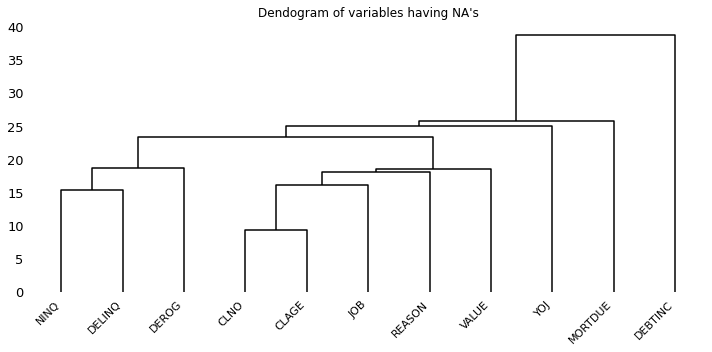

In [142]:
na_dendogram(data, export = True)

**Distribution of target variable**

In [143]:
def default_distribution_plot(df:pd.DataFrame, target:str = 'BAD', export:bool = False):  
    
    #Replacing the Booleans with non-default/default strings for visualization
    df_plot = df[target].copy().replace({0: 'Non-default', 1: 'Default'})

    #Figure's initialization
    plt.figure(figsize = (8, 6))
    
    #Default distribution
    sns.countplot(df_plot, order = reversed(df_plot.unique()), palette = 'BuPu')
    
    plt.title('Default Distribution', fontsize = 13, fontweight=  'bold')
    plt.xticks(fontsize = 11)
    plt.xlabel(None)

    #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    
    #Exporting plot
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Default_Distribution.jpg', dpi = 1200)

    plt.show()

- As can be seen, the class is imbalanced (circa 80% loans haven't defaulted, whereas 20% have defaulted).
- One would say to treat this issue with undersampling or oversampling.
  - With respect to the former case, I don't deem it appropriate since we would lose a significant amount of information.
  - With respect to the latter case, I don't deem it appropriate as well since by replicating minority instances, we would generate data which wouldn't exist in real life, therefore the model wouldn't be generalizing at all.

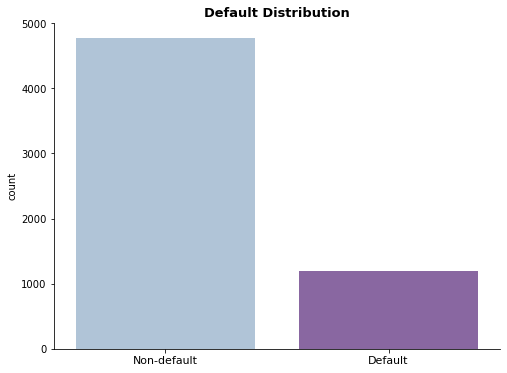

In [144]:
default_distribution_plot(data, export = True)

**Distribution of continuous features**
- conditional on the target variable.
- Distrubtion visualized either with boxplots, violionplots or histograms.

In [145]:
def continuous_distribution_plot(df: pd.DataFrame, cont_vars: list,
                                 plot_type: str, target: str = 'BAD', 
                                 export: bool = False):

    #Possible plot types
    plot_types = {'boxplot': sns.boxplot,
                  'violinplot': sns.violinplot,
                  'histogram': sns.histplot}

    #Plot type parameter check
    if plot_type not in plot_types.keys():
        raise ValueError(f'Invalid plot type. Please, select one of these available plot types: {", ".join([key for key in plot_types.keys()])}')

    #Plot either boxplots or violinplots
    if plot_type in ['boxplot', 'violinplot']:
        
        #replace 0/1's with (Non)-default texts for visualization's sake.
        df_plot = df.copy()
        df_plot[target] = df_plot[target].replace({0: 'Non-default', 1: 'Default'})

        #Figure's and axes' initialization
        fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (11, 25))

        for ax, var in zip(axs.ravel(), cont_vars):
            
            #Boxplot/violinplot
            plot_types[plot_type](data = df_plot, x = target, y = var, ax = ax,
                                  palette = 'BuPu', order = ['Non-default', 'Default'])

            ax.set_title(f'Distribution of {var}', size = 13)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
            ax.set(xlabel = None)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        fig.suptitle("Distribution of Continuous Features", fontsize = 16, fontweight=  'bold')
        fig.subplots_adjust(top=0.95)
        #Exporting the plots
        if export:
            os.makedirs('./plots/', exist_ok = True)
            plt.savefig(f'./plots/Continuous_Features_Distribution_{plot_type.capitalize()}s.jpg', dpi = 1200)
        plt.show()


    #Plot histograms
    elif plot_type == 'histogram':

        #Figure's and axes' initialization
        fig, axs = plt.subplots(nrows = len(cont_vars), ncols = 2, figsize = (11, 35))

        #Column index
        col_ind = 0
        #Axis index (if the value is even, the plot will be located on the left side, otherwise on the right side)
        axis_count = 0

        for ax in axs.ravel():

            #Accessing the feature name.
            var = cont_vars[col_ind]
            #Subsetting the data based on the feature.
            var_series = df[var]

            #Calculating the bin size for given feature ensuring that both conditional plots (left and right) will have the same number of bins.
                #Using rule of thumb (Scott, 1979) - https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
       
            R = var_series.max() - var_series.min() #Range of the feature's values
            n = len(var_series) #Number of feature's values
            sigma = var_series.std() #Standard deviation of the feature's values
        
            #Number of bins
            no_bins = int(R*(n**(1/3))/(3.49*sigma))

            #The left side (even axis_count) depicts the features' distribution conditional on the non-default cases.
            if axis_count % 2 == 0:
                #Subsetting the data for non-default cases only.
                df_subset= df.query(f'{target} == 0')
                #Number of missing values within given feature
                no_missings = df_subset[var].isna().sum()
                #Percentage of missing values within subset of given feature (i.e., percentage of missing values of given feature within the non-default cases)
                pct_missings = no_missings/df_subset.shape[0] * 100

                #Histogram with kernel density function
                plot_types[plot_type](data = df_subset, x = var, ax = ax, bins = no_bins,
                                binrange = ((var_series.min(), var_series.max())), #binrange to ensure that both left and right plot will have the same data range.
                                kde = True, color = 'lightblue')
 
                ax.set_title(f'Distribution of {var} (Non-default cases)', size = 13)
                ax.tick_params(axis = 'both', which = 'major', labelsize = 11, rotation = 30)
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                #Inserting a text box with an information about the missing values.
                ax.text(0.7, 0.9, f"Number of NA's: {no_missings} ({pct_missings:.1f}%)",
                       horizontalalignment = 'center', verticalalignment = 'center',
                       transform = ax.transAxes, bbox = dict(facecolor = 'pink', alpha = 0.3))

            #The right side (odd axis_count) depicts the features' distribution conditional on the default cases.
            else:
                #Subsetting the data for default cases only.
                df_subset = df.query(f'{target} == 1')
                #Number of missing values within given feature
                no_missings = df_subset[var].isna().sum()
                #Percentage of missing values within subset of given feature (i.e., percentage of missing values of given feature within the default cases)
                pct_missings = no_missings/df_subset.shape[0] * 100

                #Histogram with kernel density function
                sns.histplot(data = df_subset, x = var, ax = ax, bins = no_bins,
                                binrange = ((var_series.min(), var_series.max())), #binrange to ensure that both left and right plot will have the same data range.
                                kde = True, color = 'mediumpurple')
                
                ax.set_title(f'Distribution of {var} (Default cases)', size = 13)
                ax.tick_params(axis = 'both', which = 'major', labelsize = 11, rotation = 30)
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                #Inserting a text box with an information about the missing values.
                ax.text(0.7, 0.9, f"Number of NA's: {no_missings} ({pct_missings:.1f}%)",
                        horizontalalignment = 'center', verticalalignment = 'center',
                        transform = ax.transAxes, bbox = dict(facecolor = 'pink', alpha = 0.3))
                
                #Proceeding with the next feature
                col_ind += 1

            #Switching to the left/right side of the figure
            axis_count +=1
        
        plt.tight_layout()
        fig.suptitle("Distribution of Continuous Features", fontsize = 16, fontweight=  'bold')
        fig.subplots_adjust(top=0.95)
        #Exporting the plots
        if export:
            os.makedirs('./plots/', exist_ok = True)
            plt.savefig(f'./plots/Continuous_Features_Distribution_{plot_type.capitalize()}s.jpg', dpi = 1200)
    
        plt.show()

As can be seen, the features contain various outliers as well as missing values.
- Further, most of the features' distributions are positively skewed and don't follow normal distribution. 

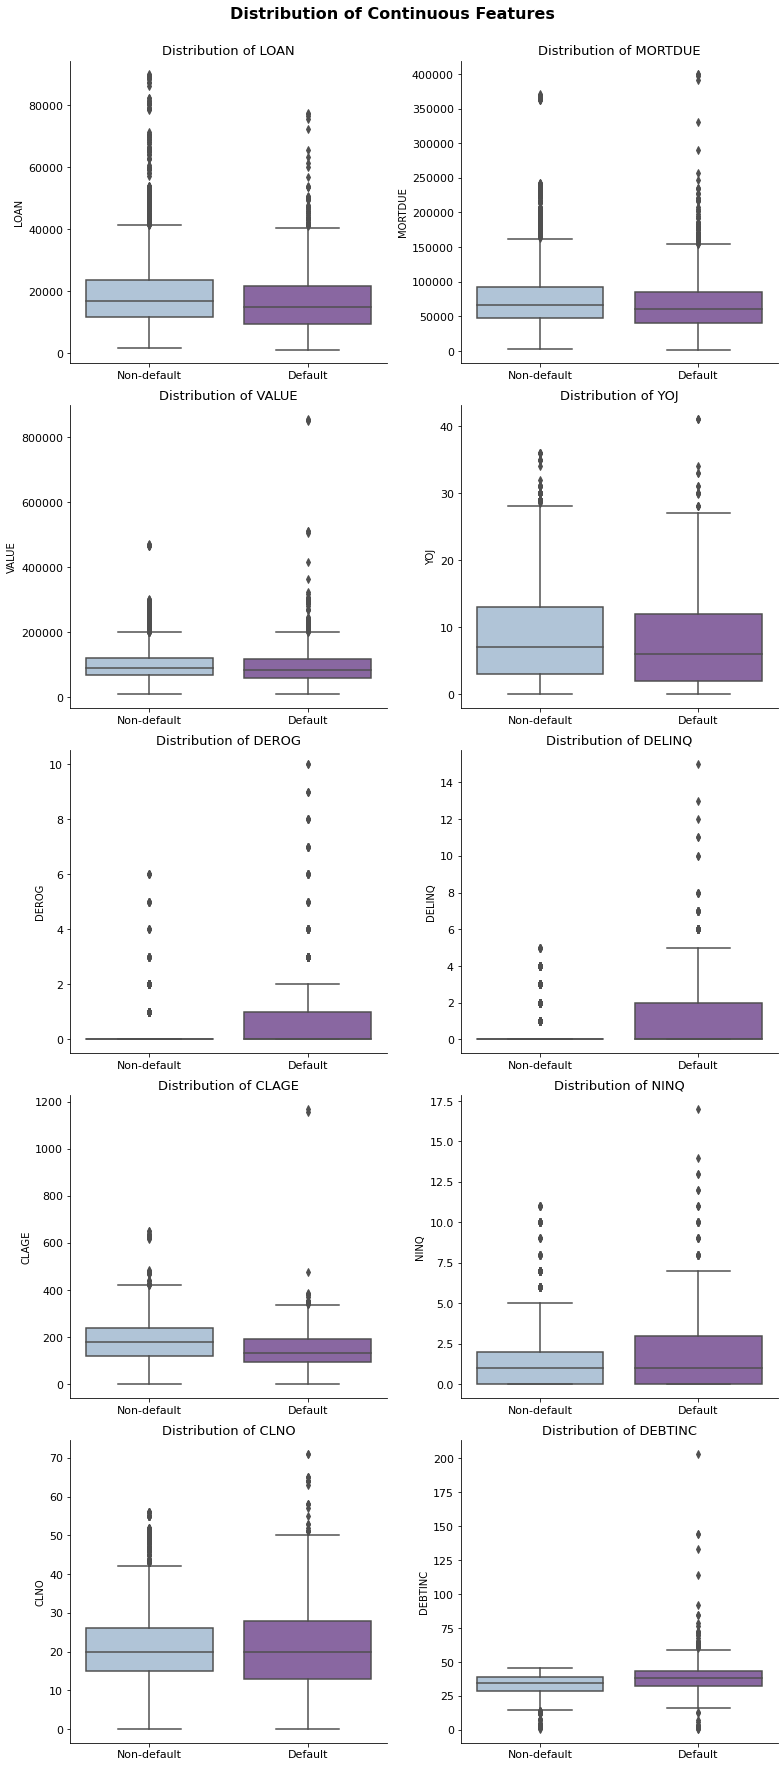

In [146]:
continuous_distribution_plot(data, cont_vars, plot_type = 'boxplot',
                             export = True)

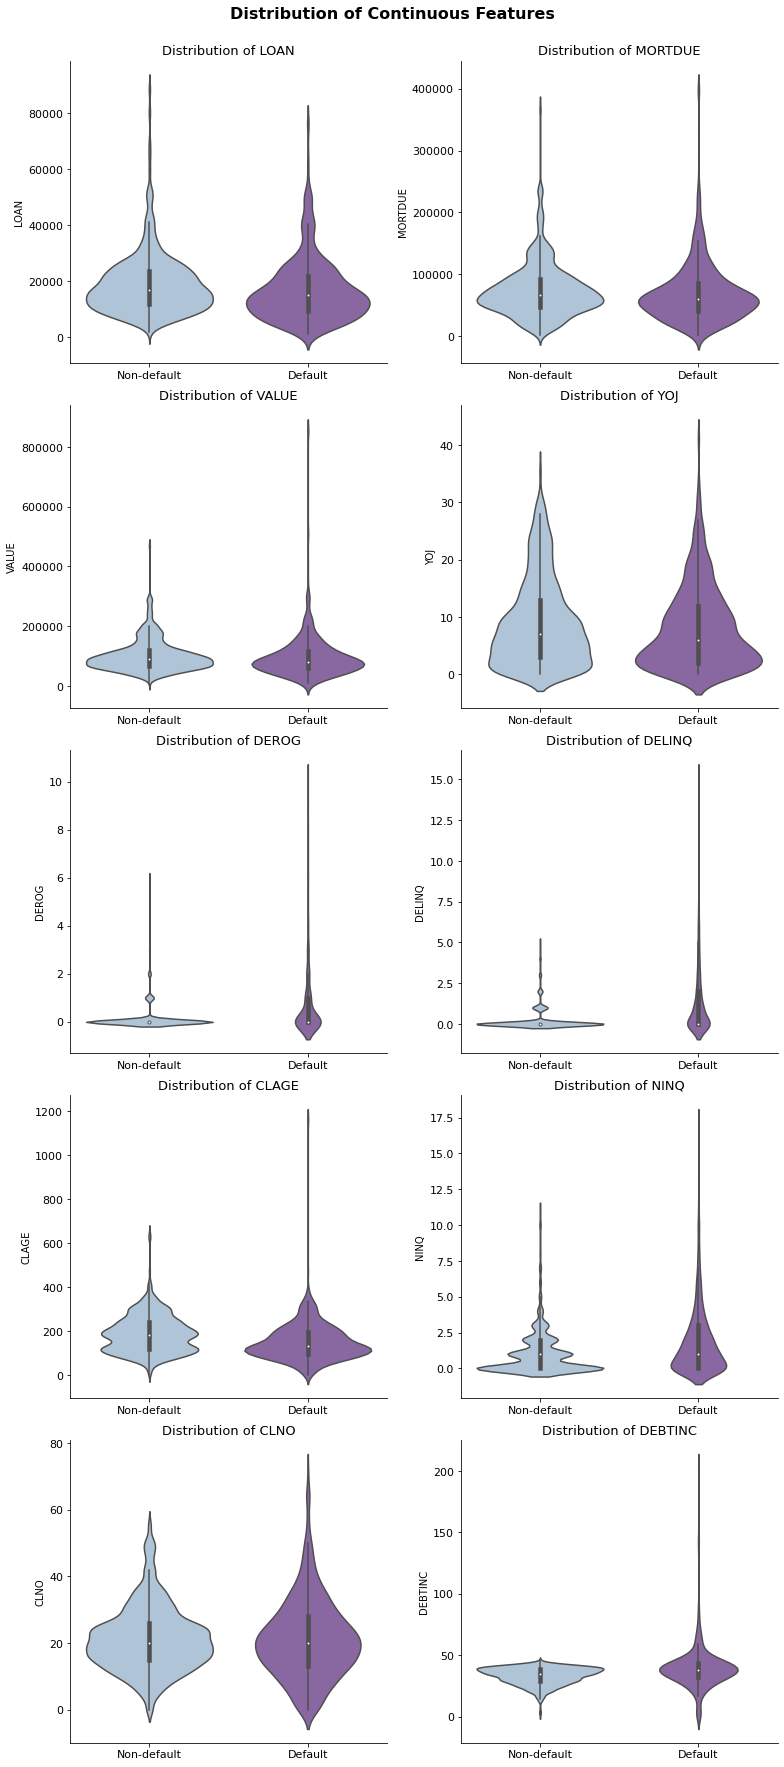

In [147]:
continuous_distribution_plot(data, cont_vars, plot_type = 'violinplot',
                             export = True)

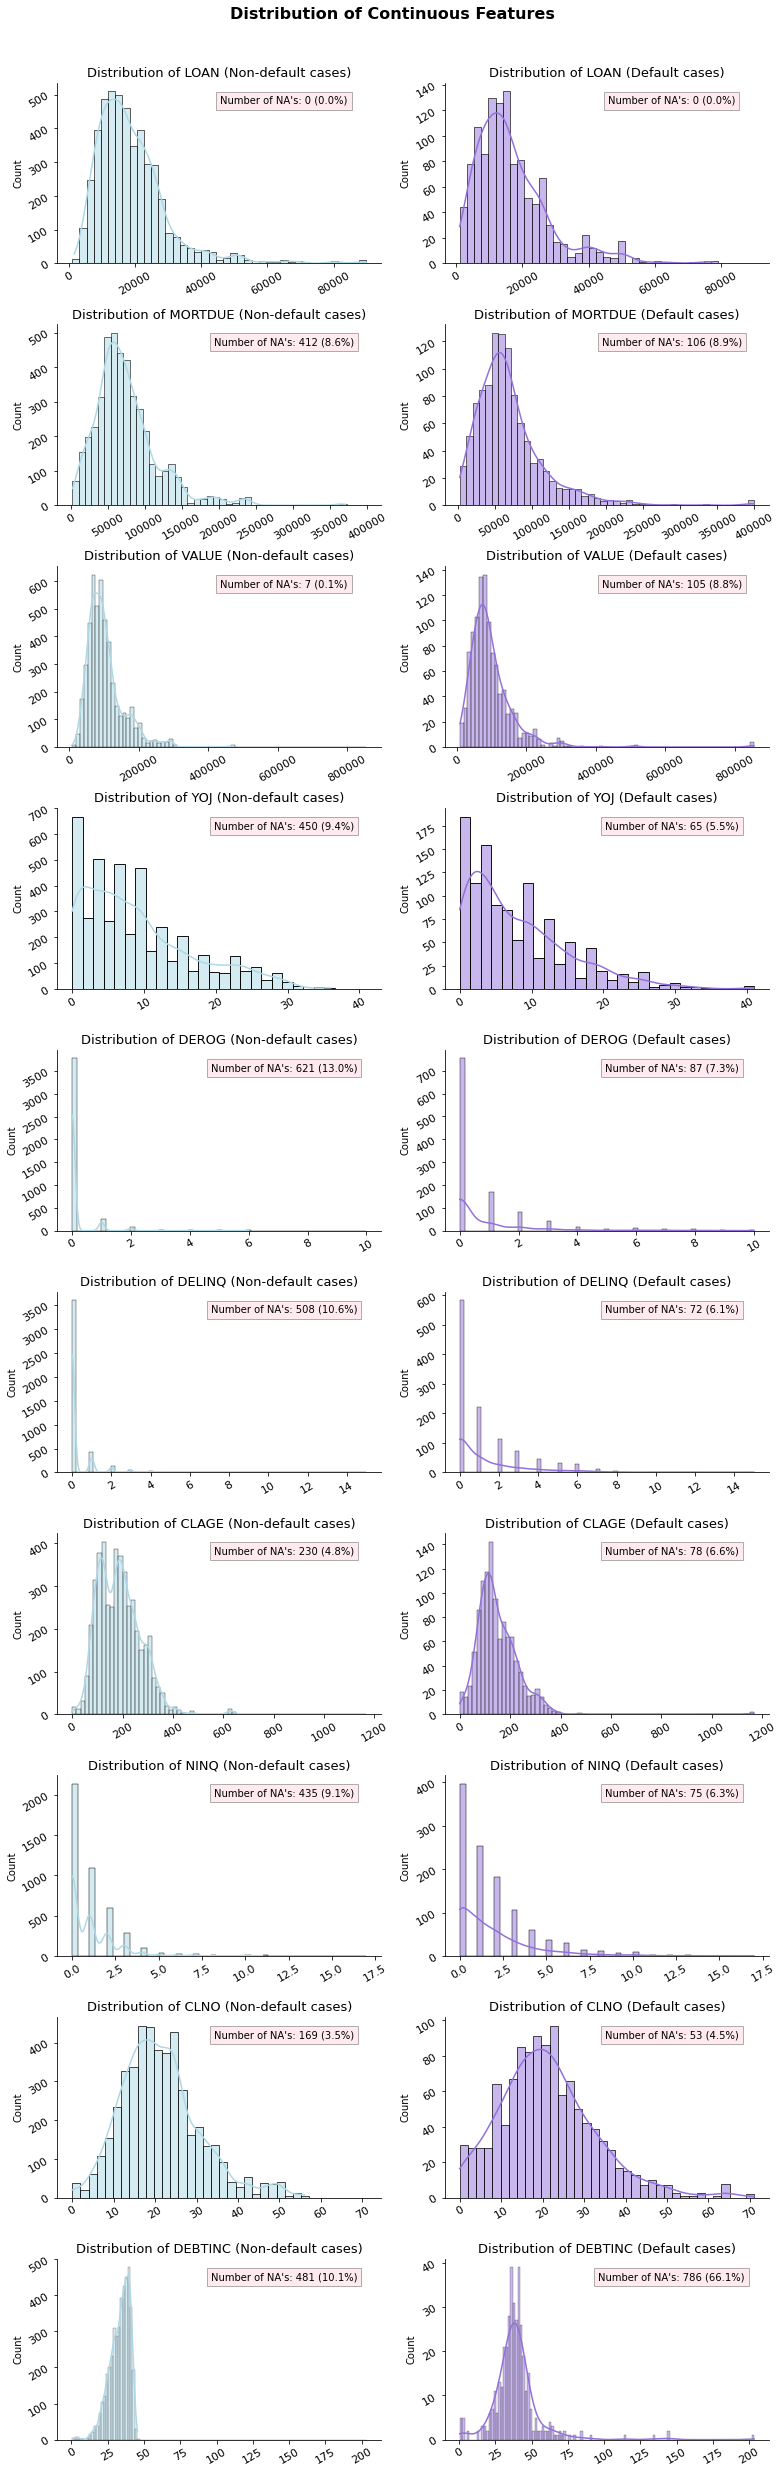

In [148]:
continuous_distribution_plot(data, cont_vars, plot_type = 'histogram')

**Distribution of categorical features**
- both uncoditional and conditional on target variable.

In [149]:
def categorical_distribution_plot(df: pd.DataFrame, cat_vars: list,
                                  target: str = 'BAD', export: bool = False):
    
    #Figure's and axes' initialization
    fig, axs = plt.subplots(nrows = len(cat_vars),ncols = 2, figsize = (11, 9))

    #Column index
    col_ind = 0
    #Axis index (if the value is even, the plot will be located on the left side, otherwise on the right side)
    axis_count = 0

    for ax in axs.ravel():

        #Accessing the feature name
        var = cat_vars[col_ind]
        #Subsetting the data based on the feature with subsequent replacing missing values with N/A's strings (for visualization's sake).
        var_target_df = df[[var, target]].copy().fillna('N/A')
        
        #If the feature has some missing values, put the N/A category at the end of the plot.
        if var_target_df.query(f'{var} == "N/A"').shape[0] != 0:
            categories = [cat for cat in var_target_df[var].unique() if cat != 'N/A'] + ['N/A']
        else:
            categories = var_target_df[var].unique()

        #The left side (even axis_count) depicts the features' distribution conditional on the non-default cases.
        if axis_count % 2 == 0:

            sns.countplot(data = var_target_df.query(f'{target} == 0'), x = var,
                          ax = ax, order = categories, color = 'lightblue')

            ax.set_title(f"Distribution of {var} (Non-default cases)", size = 13)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
            ax.set(xlabel = None)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
                        
        
        #The right side (odd axis_count) depicts the features' distribution conditional on the default cases.
        else:
            
            sns.countplot(data = var_target_df.query(f'{target} == 1'), x = var,
                          ax = ax, order = categories, color = 'mediumpurple')

            ax.set_title(f"Distribution of {var} (Default cases)", size = 13)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
            ax.set(xlabel = None)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            #Proceeding with the next feature
            col_ind += 1

        #Switching to the left/right side of the figure
        axis_count += 1

    plt.tight_layout()


    fig.suptitle("Distribution of Categorical Features", fontsize = 16, fontweight=  'bold')
    fig.subplots_adjust(top=0.90)

    #Exporting the plots
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Categorical_Features_Distribution.jpg', dpi = 1200)
        
    plt.show()

As can be seen, within the REASON feature, the relative distributions conditional on default status don't differ that much.
- Whereas, within the JOB feature, we can observe some relative differences (for instance within Self or NA (missing value) category)

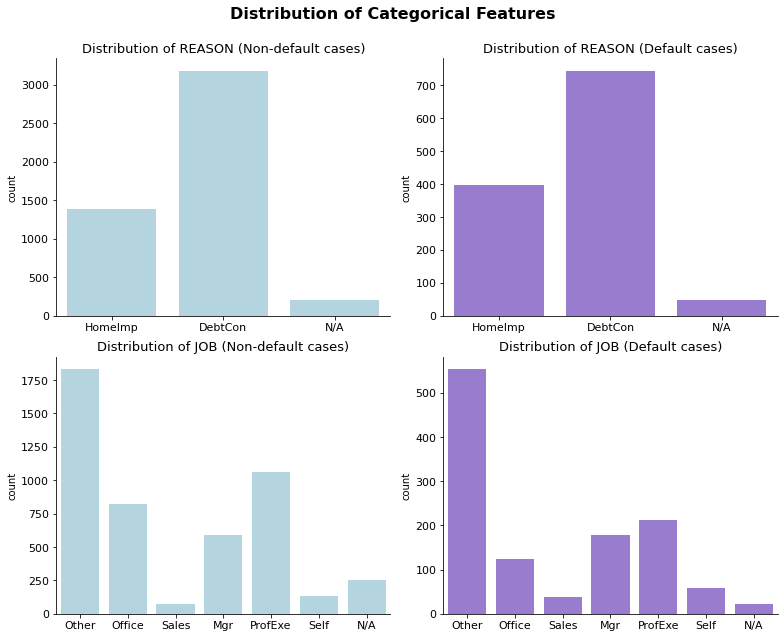

In [150]:
categorical_distribution_plot(data, cat_vars, export = True)

**Correlation between continuous features**
- We can also check for multicolinearity.
- One would use traditional Pearson correlation coefficient - however, I don't deem it approriate, since it can only measure linear relationship and also assumes that the data are normally distributed (which is not true in this case).
- Thus, I use Spearman correlation coefficient instead, which considers the nonlinearity.
$$\rho_{spearman} = 1-\frac{6 \sum_{i=1}^{n} d^2_i}{n \left(n^2-1 \right)}$$

In [151]:
def spearman_corr_matrix_plot(df: pd.DataFrame, cont_vars: list, export: bool = False):

    #Figure's initialization
    plt.figure(figsize = (12,12))

    #Corelation matrix heatmap
    sns.heatmap(df[cont_vars].corr(method = 'spearman'), vmin = -1, vmax = 1,
                mask = np.triu(np.ones_like(df[cont_vars].corr())),
                annot = True, cmap  = 'coolwarm',  fmt = '.3f')
            
    plt.title('Spearman Correlation Matrix of Continuous Features', size = 15, fontweight=  'bold')

    plt.tight_layout()

    #Exporting the plots
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Spearman_Correlation_Matrix_Continuous_Features.jpg', dpi = 1200)
    
    plt.show()

We can see that the VALUE and MORTDUE are strongly and positively associated.

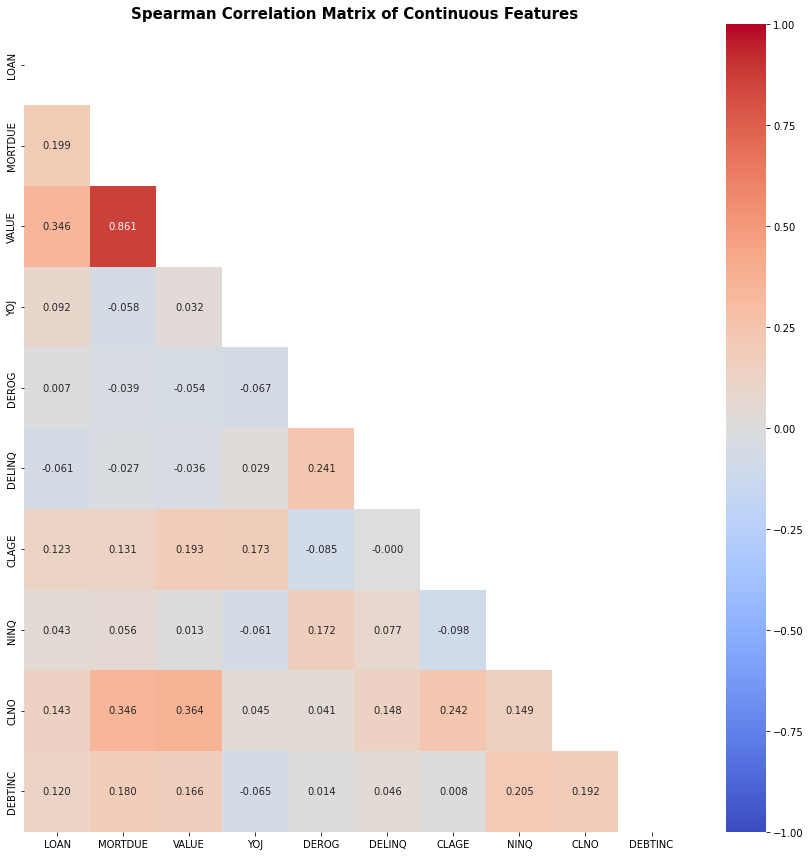

In [152]:
spearman_corr_matrix_plot(data, cont_vars, export = True)

**Association between continuous features and target variable**
- I use a point biserial correlation coefficient which measures strength and direction of the relationship between the continuous feature and binary variable.
$$r_X = \frac{\mu \left(X \;\middle|\; Y = 1 \right) - \mu_X}{\sigma_X} \sqrt{\frac{\Pr \left(Y = 1 \right)}{1 - \Pr \left(Y = 1\right)}}$$

In [153]:
def pointbiserial_corr_plot(df: pd.DataFrame, cont_vars: list,
                            target: str = 'BAD', export: bool = False):

    coef_name = 'Point Biserial coefficient'

    pointbis_corrs_df = pd.DataFrame(columns = [coef_name], index = cont_vars)

    for cont in cont_vars:

        filtered_df = df[df[cont].notna()]
        pointbis_corr = pointbiserialr(filtered_df[target], filtered_df[cont])[0]
        pointbis_corrs_df.loc[cont, coef_name] = pointbis_corr

    pointbis_corrs_df = pointbis_corrs_df.astype('float64')

    plt.figure(figsize = (3, 5))
    sns.heatmap(pointbis_corrs_df, vmin = -1, vmax = 1, annot = True, cmap  = 'coolwarm', fmt = '.3f')
    plt.title('Point Biserial Correlation between \n the Continuous Features and Default', size = 13, fontweight=  'bold')
    plt.tight_layout()
 
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Point_Biserial_Correlation_Continuous_Features_Default.jpg', dpi = 1200)
    plt.show()

As can be seen, DEROG and DELINQ are quite positively associated with default status. Even though that other continous features don't have a strong association with default status, we can't rely on such measure, since it only captures an univariate relationship. Those features can be significant in a multivariate dimension.

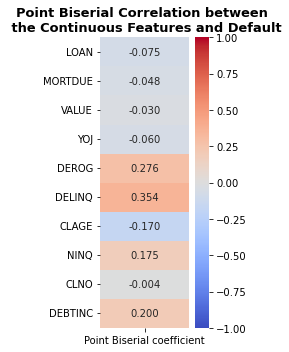

In [154]:
pointbiserial_corr_plot(data, cont_vars, export = True)

TBD:

In [155]:
def matthews_corr_feat_na_plot(df: pd.DataFrame, target: str = 'BAD', export: bool = False):

    df_ = df.drop(target, axis = 1).copy()
    
    matthews_contna_df = pd.DataFrame(columns = df_.columns, index = df_.columns)


    for cont1 in df_.columns:
        temp = df_.drop(cont1, axis = 1)
        if df_[cont1].dtypes == 'O':
            bool_var_nas_1 = [1 if type(i) != type('') else 0 for i in df_[cont1]]
        else:
            bool_var_nas_1 = [1 if math.isnan(i) == True else 0 for i in df_[cont1]]
        for cont2 in temp.columns:
            if temp[cont2].dtypes == 'O':
                bool_var_nas_2 = [1 if type(i) != type('') else 0 for i in temp[cont2]]
            else:
                bool_var_nas_2 = [1 if math.isnan(i) == True else 0 for i in temp[cont2]]
            matth_corr = matthews_corrcoef(bool_var_nas_1, bool_var_nas_2)
            matthews_contna_df.loc[cont1, cont2] = matth_corr

    matthews_contna_df = matthews_contna_df.astype('float64')
    matthews_contna_df.index = [f'{col}_IS_NA' for col in df_.columns]
    matthews_contna_df.columns = [f'{col}_IS_NA' for col in df_.columns]

    plt.figure(figsize = (15, 15))
    sns.heatmap(matthews_contna_df, vmin = -1, vmax = 1, annot = True, fmt = '.3f',
                mask = np.triu(np.ones_like(matthews_contna_df)), cmap  = 'coolwarm')
    
    plt.title("Matthews correlation between the missing observations of Continuous Features", size = 13, fontweight=  'bold')
        #Exporting the plots
    plt.tight_layout()
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Matthews_Correlation_NA_Features.jpg', dpi = 1200)

    plt.show()

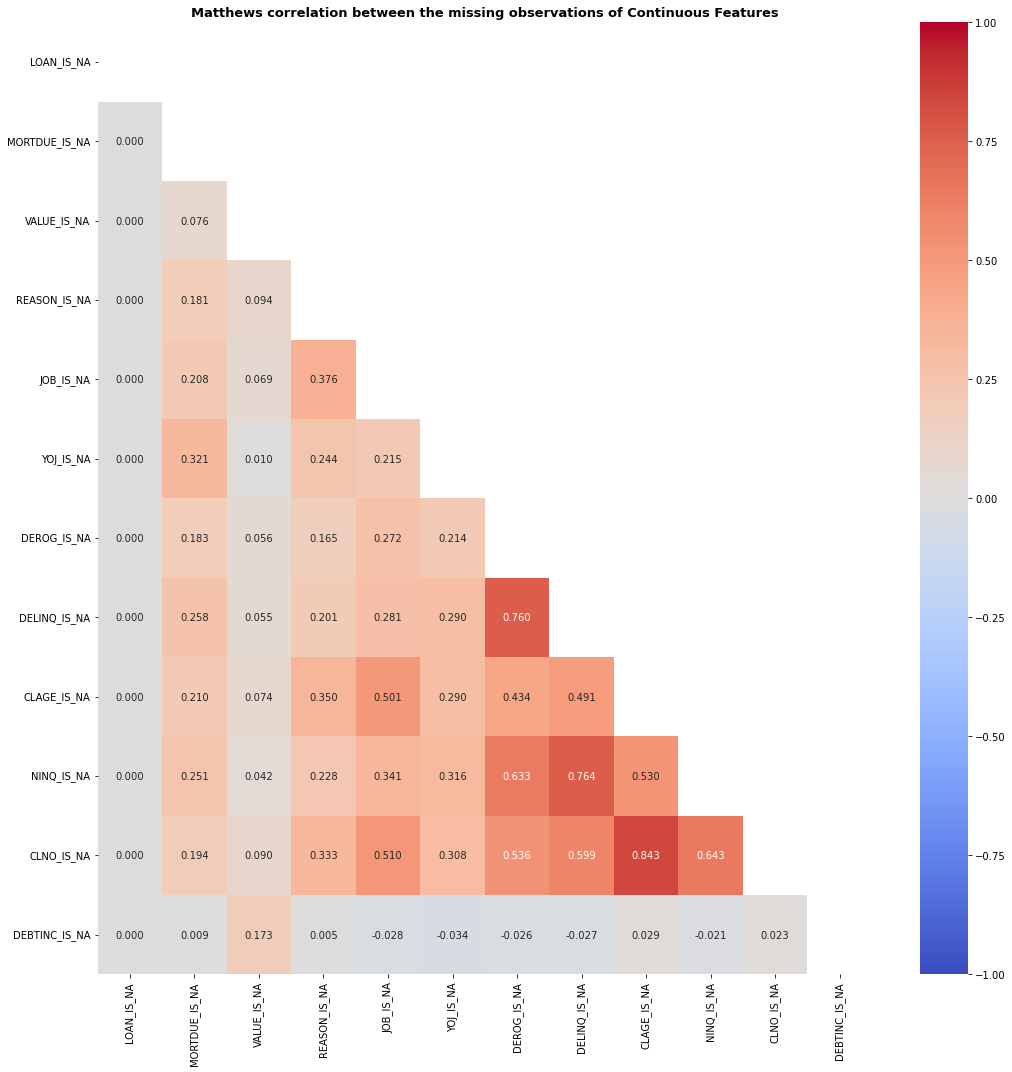

In [156]:
matthews_corr_feat_na_plot(data, export = True)

TBD:

In [157]:
def matthews_corr_contna_default_plot(df: pd.DataFrame, cont_vars: list, target: str = 'BAD'):

    coef_name = 'Matthews coefficient'

    matthews_contna_default_df = pd.DataFrame(columns = [coef_name], index = cont_vars)

    for cont in cont_vars:
        bool_var_nas = [1 if math.isnan(i) == True else 0 for i in df[cont]]
        matth_corr = matthews_corrcoef(df[target], bool_var_nas)
        matthews_contna_default_df.loc[cont, coef_name] = matth_corr

    matthews_contna_default_df = matthews_contna_default_df.astype('float64')
    matthews_contna_default_df.index = [f'{col}_IS_NA' for col in cont_vars]

    plt.figure(figsize = (2, 5))
    sns.heatmap(matthews_contna_default_df, vmin = -1, vmax = 1, annot = True, fmt = '.3f', cmap  = 'coolwarm', cbar_kws={'shrink': 0.90})
    plt.title('Matthews Correlation between \n the missing occurences of Continuous Features and Default', size = 13, fontweight=  'bold')
    plt.show()

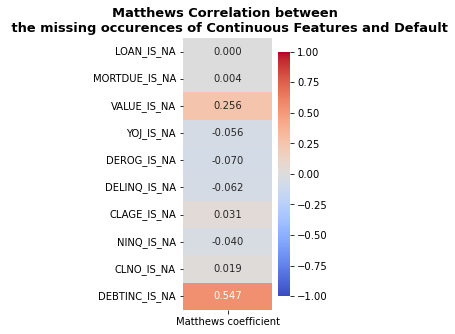

In [158]:
matthews_corr_contna_default_plot(data, cont_vars)

add Cramer's V (for measuring association between categorical variables)

## **Data Processing**

**Slit of data**
- Stratification to ensure the same target distribution across the samples.
- Split into training set (for training the models, hyperparameter tuning and feature selection), validation set (for the model selection) and test set (for evaluation of the final model)

In [160]:
def data_split(df: pd.DataFrame, test_size: float,
               validation_size: float, seed: int,
               oversampling: bool = False,
               target: str = 'BAD') -> tuple[pd.DataFrame, pd.Series,
                                             pd.DataFrame, pd.Series,
                                             pd.DataFrame, pd.Series]:
    
    #Separating the target variable (Y) and the features (X)
    Y = df[target]
    X = df.drop(target, axis = 1)

    #Stratified split into training set, validation set and test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, stratify = Y, test_size = test_size, random_state = seed)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify = y_temp, test_size = validation_size, random_state = seed)

    #Optional SMOTE oversampling of the training set.
    if oversampling:
        
        #indices of categorical variables
        cat_vars_ind = [ind for ind, i in enumerate(X_train.columns) if X_train[i].dtypes == 'O']
        cat_vars = X_train.columns[cat_vars_ind]
        cont_vars = [col for col in X_train.columns if col not in cat_vars]

        #SMOTE initialization
        smote = SMOTENC(random_state = seed, categorical_features = cat_vars_ind)
        
        #Temporary imputing of missing values (separately for categorical and continuous features)
            #SMOTE cannot work with NA's, thus we replace them with arbitrary values.
        X_train_imputed = pd.concat((X_train[cat_vars].copy().fillna('NAN'),
                                     X_train[cont_vars].copy().fillna(99999999999999)),
                                    axis = 1)[X_train.columns]

        #Fitting the SMOTE
        X_train_final, y_train_final = smote.fit_resample(X_train_imputed, pd.DataFrame(y_train).astype('int64'))

        #Replacing the NA's strings back to NA's with respect to the categorical features.
        X_train_final = X_train_final.replace({'NAN': np.nan})

        #Replacing back the missing values (99999999999999) with NA's in such case whether the value is exceeding the maximum value of given continuous feature before imputing.
        for cont in cont_vars:
            max_value = X_train[cont].max()
            X_train_final[cont] =  X_train_final[cont].apply(lambda x: np.nan if x > max_value else x) 

        #Convert target from Data Frame to Series
        y_train = y_train_final['BAD']

        return  X_train_final, y_train_final, X_valid, y_valid, X_test, y_test

    else:
        return X_train, y_train, X_valid, y_valid, X_test, y_test

In [161]:
X_train, y_train, X_valid, y_valid, X_test, y_test = data_split(data, test_size, validation_size, seed)

Some info about the split data

In [162]:
def print_data_info(**kwargs):
    
    for name, x_set in kwargs.items():

        no_dashes = 35
        no_dashes_name_left = int((no_dashes - len(name) - 1)/2)*"-"
        no_dashes_name_right  = f"{(no_dashes - len(name) - len(no_dashes_name_left) - 2)*'-'}"
        data_info = f'{x_set.shape[0]} instances, {x_set.shape[1]} features'
        no_spaces_data_info_left = int((no_dashes - len(data_info) - 1)/2)*"-"
        no_spaces_data_info_right = f'{(no_dashes - len(data_info) - len(no_spaces_data_info_left) - 2)*"-"}'
        
        print(no_dashes*'-')
        print(f'{no_dashes_name_left} {name} {no_dashes_name_right}')
        print(f'{no_spaces_data_info_left} {data_info} {no_spaces_data_info_right}')
        print(no_dashes*'-', '\n')

In [163]:
print_data_info(Training = X_train, Validation = X_valid, Test = X_test)

-----------------------------------
------------- Training ------------
--- 4171 instances, 12 features ---
----------------------------------- 

-----------------------------------
------------ Validation -----------
---- 895 instances, 12 features ---
----------------------------------- 

-----------------------------------
--------------- Test --------------
---- 894 instances, 12 features ---
----------------------------------- 



**Optimal binning and WoE encoding**
- I use **BinningProcess** use **optbinning** library which optimally dicretizes both continous features into intervals and categorical features into subgroups of categories and then transforms the intervals and and subgroups (bins) using Weight-of-Evidence: 

$$WoE_{i}= \ln \left(\frac{\Pr{\left(X = x\;\middle|\;Y = 0\right)}}{\Pr{\left(X = x\;\middle|\;Y = 1\right)}}\right)$$

- As can be seen in the function below, I fit the **BinningProcess** object on the training set only and then transform training, validation and test set (in order to avoid the data leakage).
- Instead of removing outliers, they will be captured within the lowest or highest bins intervals.
- The missing values will not be removed or imputed as well, since they will be treated as special bins.


In [164]:
def woe_binning(x_train_set: pd.DataFrame, y_train_labels: pd.Series,
                cat_vars: list, export: bool = True,
                **kwargs) -> tuple[dict, pd.DataFrame]:


    binning_path = './models/feature_preprocessing/'
    final_objects_path = './models/objects_FINAL/'

    #Initializing the binning process object.
    bn = BinningProcess(variable_names = list(x_train_set.columns), categorical_variables = cat_vars)

    #Fitting the binning on training set.
    bn.fit(x_train_set, y_train_labels)

    #DataFrame including binned categories' information.
    bins_woe = pd.DataFrame()

    for i in x_train_set.columns:
        
        var = bn.get_binned_variable(i).binning_table.build()
        var = var[(~var['Bin'].isin(['Special'])) & (~var.index.isin(['Totals']))]
        var['Variable'] = i

        bins_woe = pd.concat((bins_woe, var))

    bins_woe = bins_woe.loc[:, ~bins_woe.columns.isin(['IV','JS'])]
        
    if export:
        for save_path in [binning_path, final_objects_path]:
            os.makedirs(save_path, exist_ok = True)
            bn.save(f'{save_path}binning_woe_object.h5')
            bins_woe.to_csv(f'{save_path}woe_bins.csv', index = False)

    #Transforming both training set and test set based on the fitted training binning.
    def woe_bin_transform(bn_fit, x_set):
        x_set_binned = bn_fit.transform(x_set, metric = 'woe')
        x_set_binned.index = x_set.index
        
        return x_set_binned
    
    X_binned_sets = {'X_train_binned': woe_bin_transform(bn, x_train_set)}
    x_set_copy = X_binned_sets['X_train_binned'].copy()

    for col in x_set_copy.columns:
        na_woe = bins_woe.query('Variable == @col and Bin == "Missing"')['WoE'].values[0]
        x_set_copy.loc[x_train_set[col].isna(), col] = na_woe
    X_binned_sets['X_train_binned'] = x_set_copy

    for name, x_set in kwargs.items():
        X_binned_sets[f'{name}_binned'] = woe_bin_transform(bn, x_set)
        x_set_copy = X_binned_sets[f'{name}_binned'].copy()
        for col in x_set_copy.columns:
            na_woe = bins_woe.query('Variable == @col and Bin == "Missing"')['WoE'].values[0]
            x_set_copy.loc[x_set[col].isna(), col] = na_woe
        X_binned_sets[f'{name}_binned'] = x_set_copy

    return (X_binned_sets, bins_woe, bn)

In [165]:
X_binned_sets, woe_bins, binning_transformator = woe_binning(X_train, y_train, cat_vars, X_valid = X_valid, X_test = X_test)

In [166]:
X_train_binned, X_valid_binned, X_test_binned = (x_set for _, x_set in X_binned_sets.items())

In [167]:
X_train_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2353,0.021652,0.271560,0.312694,0.060674,0.227974,-0.344280,0.208984,0.442888,-0.177086,0.269463,0.172234,-1.051481
4593,0.294660,-0.423990,-3.787489,0.060674,-0.660856,-0.344280,-1.315486,0.442888,0.323603,0.269463,0.172234,-1.845570
2110,0.021652,0.072519,0.072874,0.060674,0.227974,0.093742,0.208984,-0.867265,0.846376,0.093061,0.127892,1.569097
2346,0.021652,-0.003300,-0.930062,0.060674,-0.179486,0.093742,0.565640,0.547877,-0.567830,-0.252955,-0.722519,1.279616
4539,0.294660,0.271560,1.185559,0.060674,0.227974,0.093742,0.208984,0.442888,0.362160,0.269463,0.532218,-1.051481
...,...,...,...,...,...,...,...,...,...,...,...,...
2066,0.021652,-0.423990,0.072874,0.060674,-0.213595,0.483777,0.565640,0.547877,-0.255264,0.411735,-0.092912,1.146451
2981,0.171642,-0.029859,0.072874,0.060674,0.227974,-0.225287,0.208984,0.442888,0.719945,-0.252955,-0.044543,1.279616
1785,0.021652,0.271560,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,-0.252955,0.172234,1.146451
5063,0.294660,-0.029859,0.072874,0.060674,-0.179486,0.093742,0.208984,0.442888,-0.177086,0.093061,0.172234,-1.051481


In [168]:
X_valid_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
743,-0.216081,-0.393497,0.072874,-0.147881,0.402165,0.658815,0.208984,0.442888,0.846376,0.093061,0.127892,1.146451
3192,0.303481,-0.423990,0.072874,0.060674,-0.179486,-0.344280,0.208984,0.442888,0.362160,0.269463,-0.722519,1.146451
3214,0.303481,0.072519,-3.787489,0.060674,0.402165,0.658815,0.208984,0.442888,-0.003300,0.093061,0.172234,1.279616
3383,0.303481,0.072519,0.312694,-0.147881,0.227974,0.658815,0.208984,0.442888,0.362160,0.269463,0.532218,1.146451
2042,0.021652,0.072519,0.312694,-0.147881,0.227974,0.093742,0.208984,0.442888,0.719945,0.093061,0.127892,-1.845570
...,...,...,...,...,...,...,...,...,...,...,...,...
1686,0.021652,0.271560,0.312694,-0.147881,-0.213595,0.093742,0.208984,0.442888,0.719945,0.269463,0.532218,1.569097
4822,0.294660,0.072519,0.312694,0.060674,0.402165,-0.344280,0.208984,0.442888,-0.567830,0.269463,0.172234,1.146451
2806,0.171642,0.271560,0.312694,0.060674,-0.213595,-0.225287,0.565640,0.547877,0.362160,-0.252955,-0.482873,1.146451
4056,0.909413,-0.029859,0.072874,0.060674,-0.179486,0.093742,0.208984,0.442888,-0.567830,-0.252955,0.172234,1.146451


In [169]:
X_test_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2120,0.021652,-0.423990,0.072874,0.060674,-0.213595,0.483777,0.565640,0.547877,-0.255264,0.411735,-0.092912,1.146451
2296,0.021652,0.072519,0.072874,0.060674,1.287203,0.093742,0.565640,0.547877,-0.255264,0.411735,-0.092912,1.505042
688,-0.216081,0.072519,0.312694,-0.147881,0.227974,-0.225287,0.208984,0.442888,0.362160,-0.252955,0.532218,1.569097
4508,0.294660,0.271560,-0.134034,-0.147881,-0.213595,-0.225287,0.208984,0.442888,0.362160,0.269463,0.127892,1.279616
467,-0.216081,-0.029859,0.072874,0.060674,1.287203,-0.225287,0.208984,0.442888,0.362160,-0.361934,-0.044543,1.569097
...,...,...,...,...,...,...,...,...,...,...,...,...
1926,0.021652,-0.682654,-0.184271,-0.147881,-0.179486,0.093742,0.208984,0.442888,-0.567830,0.269463,-0.722519,1.146451
3340,0.303481,0.072519,0.072874,0.060674,-0.179486,-0.344280,0.208984,0.442888,0.846376,-0.361934,0.172234,0.883138
2939,0.171642,0.271560,0.312694,0.060674,0.402165,-0.344280,0.565640,0.547877,-0.293054,-0.252955,0.172234,1.279616
5287,0.294660,-0.682654,-0.184271,0.060674,-0.179486,0.658815,0.208984,0.442888,0.846376,0.269463,0.532218,1.146451


Export of partially preprocessed data

In [170]:
def prep_data_export(features: tuple, labels: tuple,
                     ind_sets: tuple = ('Training', 'Validation', 'Test'),
                     csv_name:str = '') -> pd.DataFrame:

    df_list = []
    
    #Join each pair of features and labels data, assign to it a set indicator,
        # append to the list and then,
        #  transform that list into a data frame (and export it).
    for feat, lab, ind in zip(features, labels, ind_sets):
        
        temp = pd.concat((lab, feat), axis = 1)
        temp['set'] = ind
        df_list.append(temp)
    
    dfs = [df for df in df_list]

    final_df = pd.concat(dfs, axis = 0).sort_index()

    if len(csv_name) != 0:
        os.makedirs('./data/', exist_ok = True)
        final_df.to_csv(f'./data/{csv_name}.csv', index = False)
    
    return final_df

In [171]:
interim = prep_data_export((X_train_binned, X_valid_binned, X_test_binned),
                            (y_train, y_valid, y_test),
                            ('Training', 'Validation', 'Test'),
                            csv_name = 'interim_data')

In [172]:
interim

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,set
0,1,-1.339163,-0.682654,-0.930062,-0.147881,-0.179486,0.093742,0.208984,0.442888,-0.293054,0.093061,-0.722519,-1.845570,Training
1,1,-1.339163,0.072519,0.072874,-0.147881,-0.179486,0.093742,0.208984,-0.867265,-0.293054,0.269463,0.127892,-1.845570,Test
2,1,-1.339163,-0.393497,-0.930062,-0.147881,-0.179486,-0.225287,0.208984,0.442888,-0.177086,0.093061,0.127892,-1.845570,Validation
3,1,-1.339163,-0.003300,-3.787489,0.131178,1.287203,0.483777,0.565640,0.547877,-0.255264,0.411735,-0.092912,-1.845570,Training
4,0,-1.339163,0.271560,0.312694,-0.147881,0.402165,-0.344280,0.208984,0.442888,-0.293054,0.269463,0.127892,-1.845570,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,-0.321287,0.072519,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.146451,Training
5956,0,-0.321287,-0.029859,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.146451,Training
5957,0,-0.321287,-0.029859,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.146451,Test
5958,0,-0.321287,-0.029859,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.279616,Training


**Distribution of WoE coefficients per feature**
- negative values indicates larger distribution of defaulters in given bin ($z > 1$, hence $\ln(z) > 0$)
- positive values indicates larger distribution of non-defaulters in given bin ($z < 1$, hence $\ln(z) < 0$)

In [173]:
def woe_bins_plot(bins_woe: pd.DataFrame, export: bool = False):

    """
    Function for plotting the WoE values of each features' categories.
    
    Arguments:
        bins_woe - Data frame which contains information about binned features' categories (including WoE values).
    
    Output:
        Plot containing WoE distribution of features' categories.
    
    """

    fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 25))
    

    for i, ax in zip(bins_woe['Variable'].unique(), axs.ravel()):
    
        temp = bins_woe.loc[bins_woe['Variable'] == i]
        sns.barplot(x = temp.index, y = 'WoE', data = temp, ax = ax, palette = "BuPu")
        ax.axhline(y = 0, color = 'black', linewidth = 1)
        
        cat = False

        for j in temp['Bin']:
            if isinstance(j, np.ndarray):
                cat = True
                break
        if cat == False:
            labels = list(temp['Bin'])
 
        elif cat == True:
            labels = [k if type(k) == type('Missing') else str(list(k)).replace('[','').replace(']','').replace("'",'') for k in temp['Bin']]
        
        ax.set_title(i, size = 13)
        ax.set_xticklabels(labels, rotation = 90, size = 11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    

    fig.tight_layout()

    fig.suptitle("WoE coefficients' Distribution per Features", fontsize = 16, fontweight=  'bold')
    fig.subplots_adjust(top=0.95)
    
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/WoE_Distribution.jpg', dpi = 1200)

    plt.show()

We can observe that the bins capture non-linear pattern with respect to the target

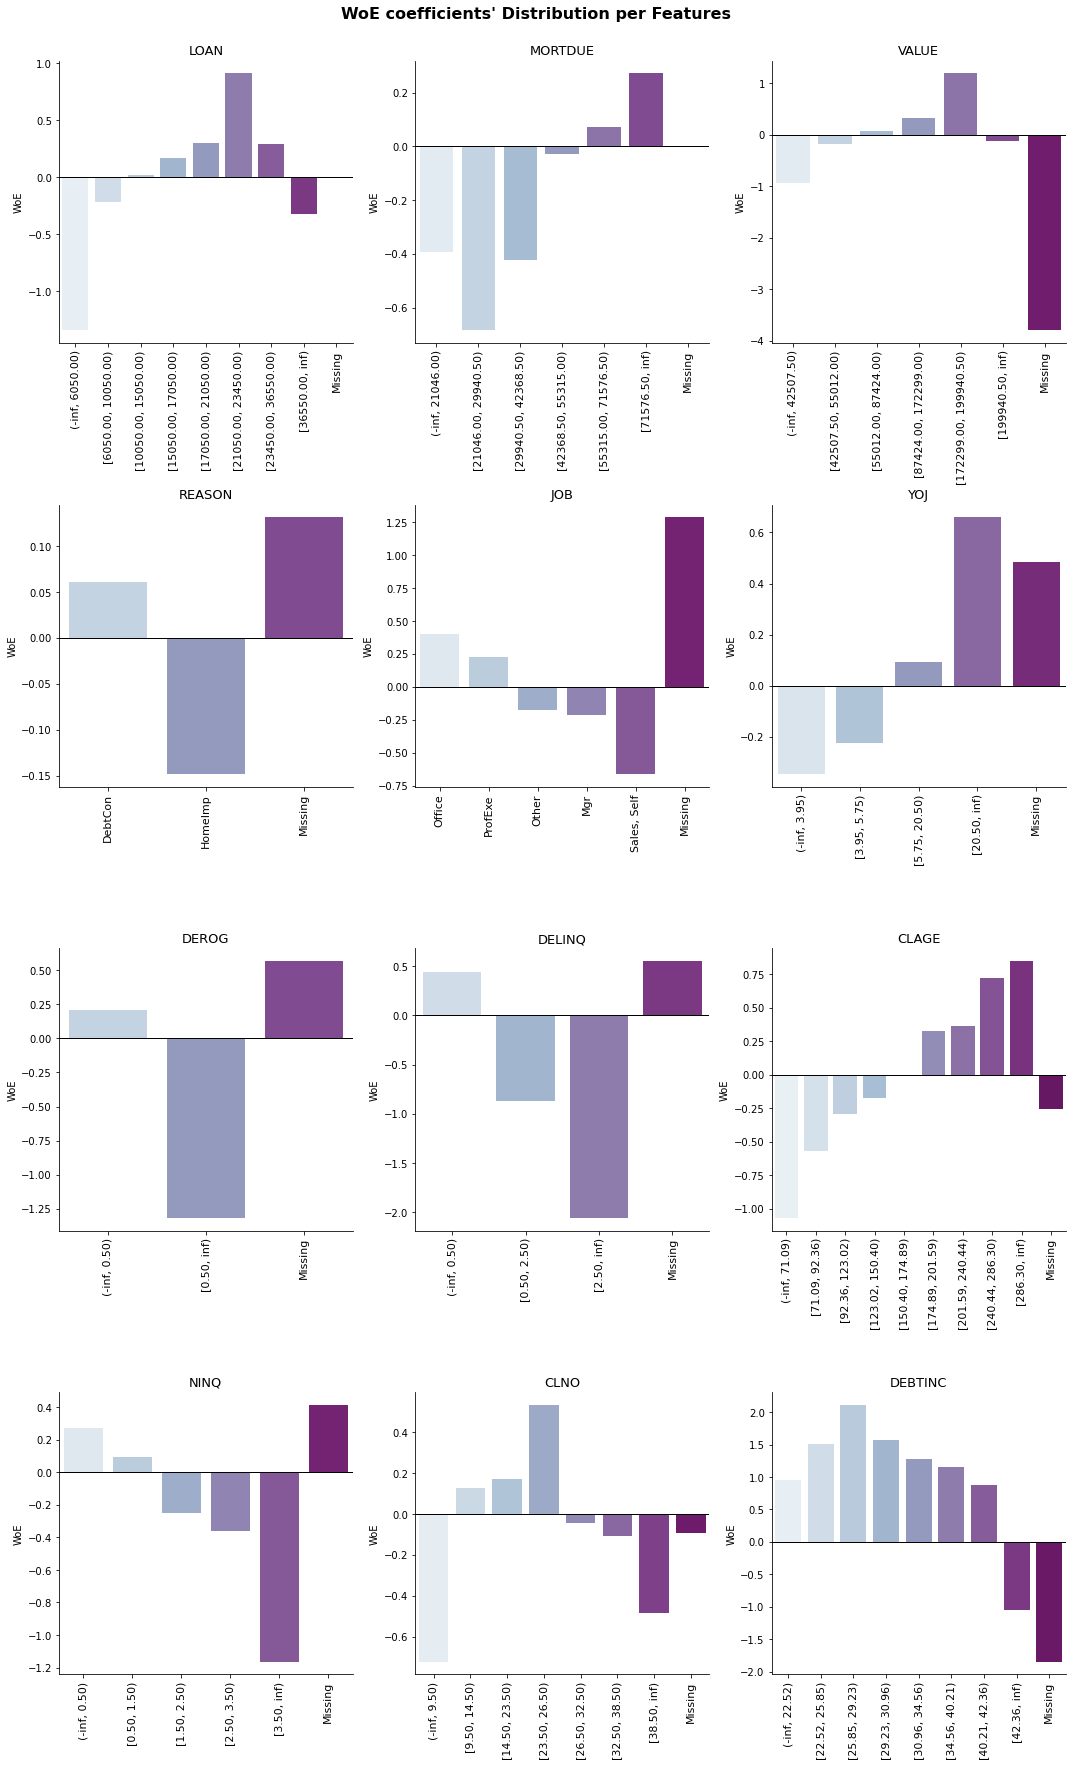

In [174]:
woe_bins_plot(woe_bins, export = True)

## **MODELLING**

Model space definition

In [175]:
models_dict = {
               'Logistic Regression': LogisticRegression(random_state = seed, n_jobs = -1),
               'Random Forest Classifier': RandomForestClassifier(random_state = seed, n_jobs = -1),
               'Gradient Boosting Classifier': GradientBoostingClassifier(random_state = seed),
                'Support Vector Classifier': SVC(probability = True, random_state = seed),
                'Multi Layer Percepton Classifier': MLPClassifier(random_state = seed)
              }

Hyperparameter tuning using Bayesian Optimization
- With stratified 10-fold cross validation with 50 iterations while maximizing an objection function (F1 score function)

In [176]:
def bayesian_optimization(model, x_train:pd.DataFrame, y_train:pd.Series, seed:int):
    
    estimator = model

    #Adjustment of max_features hyperparameter within the final model selection.
    max_features = len(x_train.columns)

    #Defining a searching space of possible ranges of hyperparameters, given the model.
    if type(model) == type(RandomForestClassifier()):

        search_space = {
                        'n_estimators': Integer(100, 1000),
                        'criterion': Categorical(['gini', 'entropy', 'log_loss']),
                        'max_depth': Integer(1, 10),
                        'max_features': Integer(3, max_features),
                        'min_samples_leaf': Integer(1, 40),
                        'min_samples_split': Integer(2, 80),
                        'class_weight': Categorical(['balanced', 'balanced_subsample', None]),
                        'bootstrap': Categorical([True, False]),
                        }


    elif type(model) == type(GradientBoostingClassifier()):

        search_space = {
                        'n_estimators': Integer(100, 1000),
                        'loss': Categorical(['log_loss', 'exponential']),
                         'max_depth': Integer(1, 10),
                         "learning_rate":Real(0.0001, 0.2, prior='log-uniform'),
                         'min_samples_leaf': Integer(4, 40),
                         'max_features': Integer(3, max_features),
                         'criterion': Categorical(['friedman_mse', 'squared_error']),
                        'min_samples_leaf': Integer(1, 40),
                        'min_samples_split': Integer(2, 80)
                        }


    elif type(model) == type(LogisticRegression()):

        search_space = {
                        'fit_intercept':  Categorical([True, False]),
                        'C': Real(0.000001, 10, prior='log-uniform'),
                        'penalty': Categorical(['l1', 'l2', 'none', 'elasticnet']),
                        'solver': Categorical(['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']),
                        'class_weight': Categorical(['balanced', None])
                        }

        for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
            if solver == 'lbfgs' or solver == 'newton-cg':
                search_space['penalty'] = Categorical(['l2', 'none'])
            elif solver == 'sag':
                search_space['penalty'] = Categorical(['l2', 'elasticnet'])
                search_space['l1_ratio'] = Real(0, 1, prior='uniform')
            elif solver == 'liblinear':
                search_space['penalty'] = Categorical(['l1', 'l2', 'none', 'elasticnet'])
                if search_space['penalty'] == 'l2':
                    search_space['dual'] = Categorical([True, False])
                if search_space['fit_intercept']:
                    search_space['intercept_scaling'] = Real(0.1, 100.0, prior='log-uniform')
            else:
                search_space['penalty'] = Categorical(['l1', 'l2', 'none', 'elasticnet'])
                search_space['l1_ratio'] = Real(0, 1, prior = 'uniform')
                search_space['solver'] = Categorical(['saga'])


    elif type(model) == type(SVC()):
        search_space = {
                        'C': Real(0.0001, 10, prior = 'log-uniform'),
                        'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree': Integer(1, 10),
                        'gamma': Categorical(['scale', 'auto']),
                        'shrinking': Categorical([True, False]),
                        'class_weight': Categorical(['balanced', None])
                       }

    
    elif type(model) == type(MLPClassifier()):
        search_space = {
                        'hidden_layer_sizes': Integer(10, 1000),
                        'activation': Categorical(['logistic', 'identity', 'tanh', 'relu']),
                        'solver': Categorical(['lbfgs', 'sgd', 'adam']),
                        'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
                        'learning_rate_init': Real(0.0001, 0.01, prior = 'log-uniform'),
                        'power_t': Real(0.1, 2, prior = 'log-uniform'),
                        'shuffle': Categorical([True, False]),
                        'momentum': Real(0.00001, 0.999999, prior = 'log-uniform'),
                        'nesterovs_momentum': Categorical([True, False]),
                        'early_stopping': Categorical([True, False]),
                        'beta_1': Real(0.00001, 0.999999, prior = 'log-uniform'),
                        'beta_2': Real(0.00001, 0.999999, prior = 'log-uniform'),
                        'epsilon': Real(1e-10, .09999999, prior = 'log-uniform'),
                        'alpha': Real(0.0001, 10, prior = 'log-uniform')
                       }
        
        
    #Initialization of the stratified 10-fold cross validation.
    stratified_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

    #Initialization of the Bayesian Optimization.
        # using the stratified 10-fold cross validation and given model, while maximizing the objective function recall score.
    bayescv = BayesSearchCV(estimator = estimator,
                            search_spaces = search_space,
                            scoring = "f1", cv = stratified_cv,
                            n_jobs = -1, n_iter = 50,
                            random_state = seed)

    #Fitting the Bayesian optimization algorithm on the training data.
    bayescv.fit(x_train, y_train)

    #Outputs the model with the best tuned hyperparameters with respect to Recall score.
    return bayescv.best_estimator_

**Feature selection - Backward Sequential Feature Selection**
- for each base model, tune its hyperparameters with Bayesian Optimization.
  - Then use this tuned model as an input estimator within backward Sequential Feature Selector to choose optimal subset of features.
- For $n$ models, we get $n$ subsets of optimal features.
- SFS uses stratified 10-fold cross validation while maximizing F1 score function.

In [177]:
def SFS_feature_selection(x_train:pd.DataFrame, y_train:pd.Series,
                   models_dict:dict, seed:int, export:bool = True) -> pd.DataFrame:
    
    def print_FS(name: str, dashes: str,
                 count: int, models_dict: dict):

        print(dashes)
        order = f'{count}/{len(models_dict.keys())}'
        no_dashes_left = int((len(dashes) - len(order) - 1)/2)*"-"
        no_dashes_right  = f"{(len(dashes) - len(order) - len(no_dashes_left) - 2)*'-'}"
        print(f'{no_dashes_left} {order} {no_dashes_right}')
        print(dashes)

        text_ = f'FEATURE SELECTION WITH {name.upper()}'
        
        no_dashes_left_ = int((len(dashes) - len(text_) - 1)/2)*"-"
        no_dashes_right_  = f"{(len(dashes) - len(text_) - len(no_dashes_left_) - 2)*'-'}"
        print(f'{no_dashes_left_} {text_} {no_dashes_right_}')
        print(dashes)
        print(dashes, '\n')


    def print_exec_time(time, number_features: int,
                        selected_feats: list, dashes: str):

        print(f'    Execution time: {round(time)} seconds', '\n')
        print(f'    {number_features} features selected: {", ".join(selected_feats)}', '\n')
        print(dashes)
        print(dashes, '\n')
        print()
        
    opt_models_path = './models/feature_selection/opt_models/'
    feat_select_path = './models/feature_selection/feat_select_objects/'
    
    #Empty list for storing all the models with their tuned hyperparameters, number of features selected, and names of selected features.
    models_feats_list = []

    #For each model, tune its hyperparameters using Bayesian Optimization.
        # Then use the tuned model for feature selection using RFE while maximizing an objective function F1 Score.
    dashes = '-------------------------------------------------------------------------------------------------------------------'
    count = 1
    
    for name, mod in models_dict.items():

        print_FS(name, dashes, count, models_dict)

        start = time.time()
        print('    1/4 ... Starting Bayesian Optimization on the whole set of features')

        opt_mod = bayesian_optimization(mod, x_train, y_train, seed)

        print('    2/4 ... Bayesian Optimization finished')

        #Initialization of the stratified 10-fold cross validation.
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

        print('    3/4 ... Starting Backward Sequential Feature Selection')

        #Initialization of the Recursive Feature Elimination 10-fold Cross Validation in order to select the optimal number of features
            # based on the model with tuned hyperparameters and maximizing F1 score function.
        sfs = SequentialFeatureSelector(mod, n_features_to_select='auto', direction = 'backward', scoring = 'f1', cv = cv, n_jobs = -1, tol = 0.0000001)
    
        sfs.fit(x_train, y_train)

        print('    4/4 ... Backward Sequential Feature Selection with finished', '\n')
        end = time.time()

        #Extracting the final selected features and number of the selected features.
        selected_feats = x_train.columns[sfs.get_support()].tolist()
        number_features = len(selected_feats)

        print_exec_time(end - start, number_features, selected_feats, dashes)
        
        if export:
            for save_path, export_obj, save_name in zip([opt_models_path, feat_select_path], [opt_mod, sfs], ['FS_opt', 'SFS_w']):
                os.makedirs(save_path, exist_ok = True)
                with open(f'{save_path}{save_name}_{name.replace(" ", "")}.h5', 'wb') as save_obj:
                    pickle.dump(export_obj, save_obj)

        models_feats_list.append([name, #name of the tuned base model
                                  opt_mod, #tuned base model
                                  sfs, #fitted SFS object
                                  number_features, #number of selected features
                                  selected_feats, #list of selected features' names
                                  end - start #execution time
                                  ])

        count += 1
    
    #Storing all the models with their tuned hyperparameters, number of features selected, and names of selected features.
    feat_sel = pd.DataFrame(models_feats_list,
                            columns = ['model_name', 'model', 'sfs_model', 'n_features',
                                       'final_features', 'execution_time'])
    
    if export:
        with open('./models/feature_selection/feat_selection_df_ORIGINAL.pkl', 'wb') as feat_select_df_save:
            pickle.dump(feat_sel, feat_select_df_save)

    return feat_sel

In [178]:
feat_selection_df = SFS_feature_selection(X_train_binned, y_train, models_dict, seed)

-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- 1/5 -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------ FEATURE SELECTION WITH LOGISTIC REGRESSION -----------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------- 

    1/4 ... Starting Bayesian Optimization on the whole set of features
    2/4 ... Bayesian Optimization finished
    3/4 ... Starting Backward Sequential Feature Selection
    4/4 ... Backward Sequential Feature Selection with finished 

    Execution time: 83 seconds 

    11 features selected: LOA

In [179]:
feat_selection_df

,model_name,model,sfs_model,n_features,final_features,execution_time
0,Logistic Regression,"LogisticRegression(C=1.1274052759827395, inter...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",83.367091
1,Random Forest Classifier,"(DecisionTreeClassifier(max_depth=10, max_feat...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DELIN...",245.398679
2,Gradient Boosting Classifier,([DecisionTreeRegressor(criterion='friedman_ms...,SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",379.761031
3,Support Vector Classifier,"SVC(C=10.0, class_weight='balanced', degree=4,...",SequentialFeatureSelector(cv=StratifiedKFold(n...,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",402.089471
4,Multi Layer Percepton Classifier,"MLPClassifier(alpha=0.31777165291946013, beta_...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",1015.065995


Recurrence of the selected features
- As can be seen, CLAGE, CLNO, DELINQ, JOB, NINQ, VALUE AND YOJ were selected by each base model.

In [180]:
def selected_features_recurrence(df: pd.DataFrame, export:bool = True):
    
    df_plot = (
                pd.get_dummies(df['final_features']
                               .apply(pd.Series)
                               .stack()
                              )
                .sum(level = 0)
                .sum()
                .reset_index()
                .rename(columns = {'index': 'Model', 0: 'Count'})
                .sort_values('Count', ascending = False)
              )
    
    df_plot.plot.bar(x = 'Model', y = 'Count', color = 'mediumpurple',
                     legend = False, figsize = (10,6))
    
    # set title and axis labels
    plt.title('Recurrence of the selected features', size = 13, fontweight = 'bold')
    plt.xlabel('Features', size = 11)
    plt.ylabel('Count', size = 11)
    plt.yticks(size = 11)
    plt.xticks(rotation = 45, size = 11)
    plt.legend().set_visible(False)
    
        #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Recurrence_Selected_Features.jpg', dpi = 1200)

    plt.show()

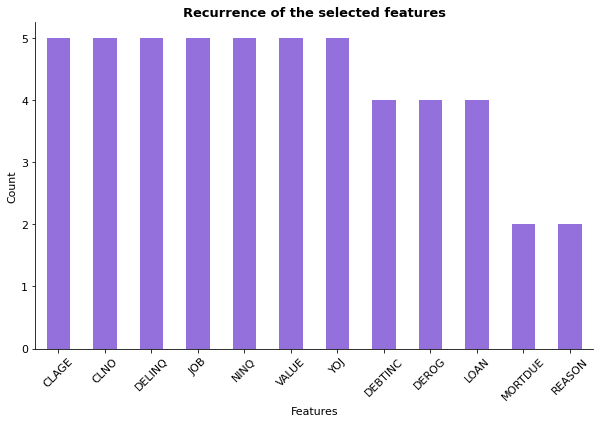

In [181]:
selected_features_recurrence(feat_selection_df)

Distribution of selected features per model

In [182]:
def selected_features_dist(df: pd.DataFrame, export: bool = True):

    df_plot = (
               pd.concat(
                         (
                          df[['model_name']],
                          pd.get_dummies(
                                         df['final_features']
                                         .apply(pd.Series)
                                         .stack()
                                        )
                          .sum(level = 0)
                         ),
                         axis = 1
                        )
               .copy()
              )
    
    df_plot['totals'] = df_plot.drop('model_name', axis = 1).sum(axis = 1)
    df_plot['model_name'] = df_plot['model_name'].str.replace('Classifier', '')
    df_plot = (
                df_plot
                .sort_values(by = 'totals',
                             ascending = False)
                .drop('totals', axis = 1)
              )
    
    df_plot.plot(
                 x = 'model_name',
                 y = [col for col in df_plot.columns if col != 'model_name'],
                 kind = 'bar',
                 stacked = True,
                 figsize = (10,6)
                )
    
    plt.title('Distribution of selected features', size = 15, fontweight = 'bold')
    plt.xlabel('Model', size = 11)
    plt.ylabel('Numver of selected features', size = 11)
    plt.xticks(rotation = 70, size = 11)
    plt.yticks(size = 11)
    plt.legend(bbox_to_anchor = (1, 1))
        #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)


    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Selected_Features_Distribution.jpg', dpi = 1200)
        
    plt.show()

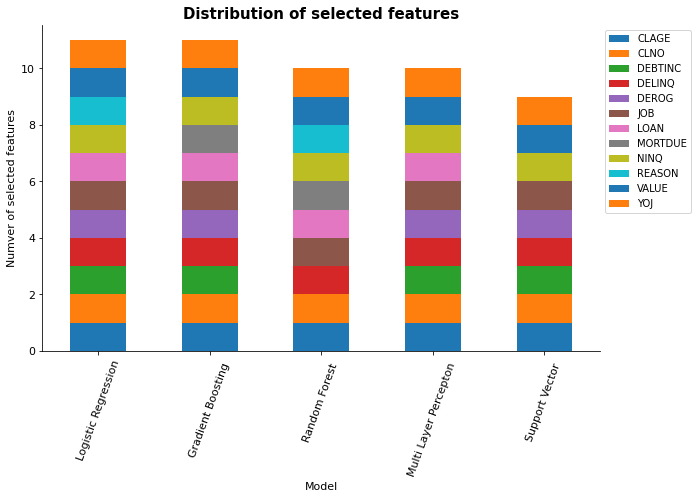

In [183]:
selected_features_dist(feat_selection_df)

Used in such case where multiple models select the same features

In [184]:
def remove_duplicated_selected_feats(df:pd.DataFrame, export:bool = True) -> pd.DataFrame:
   
   #Filtering indices of duplicated selected features
   feat_duplicated_ind = (
                            df['final_features']
                           .apply( lambda x: ', '.join(x))
                           .duplicated(keep = False)
                           .values
                          )
   if sum(feat_duplicated_ind) != 0:
      #Keeping the model which was the fastest to execute and drop the others
      duplicated_models = (
                           df[feat_duplicated_ind]
                           .sort_values('execution_time')
                           .reset_index(drop = True)
                        )
    
      drop_models = (
                   duplicated_models
                   .loc[1:,'model_name']
                   .values
                  )
      
      keep_model = duplicated_models.head(1)['model_name'].values[0]

      models_name_join = ', '.join(duplicated_models['model_name'].tolist())
      
      final_feat_selection_df = (
                                df[~df['model_name'].isin(drop_models)]
                                .reset_index(drop = True)
                                )
      
      final_feat_selection_df.loc[final_feat_selection_df['model_name'] == keep_model, 'model_name'] = models_name_join
      
   else:
      final_feat_selection_df = df.copy()

   if export:
      with open('./models/feature_selection/feat_selection_df_FINAL.pkl', 'wb') as feat_select_df_save:
         pickle.dump(final_feat_selection_df, feat_select_df_save)

   return final_feat_selection_df

In [185]:
feat_selection_df_FINAL = remove_duplicated_selected_feats(feat_selection_df)
feat_selection_df_FINAL

,model_name,model,sfs_model,n_features,final_features,execution_time
0,Logistic Regression,"LogisticRegression(C=1.1274052759827395, inter...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",83.367091
1,Random Forest Classifier,"(DecisionTreeClassifier(max_depth=10, max_feat...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DELIN...",245.398679
2,Gradient Boosting Classifier,([DecisionTreeRegressor(criterion='friedman_ms...,SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",379.761031
3,Support Vector Classifier,"SVC(C=10.0, class_weight='balanced', degree=4,...",SequentialFeatureSelector(cv=StratifiedKFold(n...,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",402.089471
4,Multi Layer Percepton Classifier,"MLPClassifier(alpha=0.31777165291946013, beta_...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",1015.065995


In [186]:
feat_selection_df_FINAL[['model_name', 'n_features', 'final_features', 'execution_time']]

,model_name,n_features,final_features,execution_time
0,Logistic Regression,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",83.367091
1,Random Forest Classifier,10,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DELIN...",245.398679
2,Gradient Boosting Classifier,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",379.761031
3,Support Vector Classifier,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",402.089471
4,Multi Layer Percepton Classifier,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",1015.065995


**Model selection**
- Take each base model, tune its hyperparameters on each subset of selected features (in the previous step) while maximizing F1 score function,
  - and then, train this tuned model and evaluate it on a validation set.
- By default, the classification threshold is 0.5, which doesn't have to be valid in practice.
  - Therefore, we calculate an optimal threshold using Youden index for cutoff point.
- Besides Recall, we also calculate F1, Precision, Accuracy, AUC, Gini, Kolmogorov-Smirnov or Brier loss.

In [187]:
def model_selection(x_train:pd.DataFrame, y_train:pd.Series, x_val:pd.DataFrame, y_val:pd.Series,
                          models_dict:dict, feat_sel:pd.DataFrame, seed:int, target:str = 'BAD', export:bool = True) -> pd.DataFrame:
    
    def print_model_selection(name: str, fs_name: str, feat_sel: pd.DataFrame,#
                              models_dict: dict, dashes: str, count: int):
        
        print(dashes)

        order = f'{count}/{len(models_dict.keys())*feat_sel.shape[0]}'
        no_dashes_left = int((len(dashes) - len(order) - 1)/2)*"-"
        no_dashes_right  = f"{(len(dashes) - len(order) - len(no_dashes_left) - 2)*'-'}"

        print(f'{no_dashes_left} {order} {no_dashes_right}')

        print(dashes)

        text_ = f'BAYESIAN OPTIMIZATION OF {name.upper()}'
        text__ = f'WITH SELECTED FEATURES BY {fs_name.upper()}'
            
        no_dashes_left_ = int((len(dashes) - len(text_) - 1)/2)*"-"
        no_dashes_right_  = f"{(len(dashes) - len(text_) - len(no_dashes_left_) - 2)*'-'}"
        no_dashes_left__ = int((len(dashes) - len(text__) - 1)/2)*"-"
        no_dashes_right__  = f"{(len(dashes) - len(text__) - len(no_dashes_left__) - 2)*'-'}"     

        print(f'{no_dashes_left_} {text_} {no_dashes_right_}')
        print(f'{no_dashes_left__} {text__} {no_dashes_right__}')
        print(dashes)
        print(dashes, '\n')
    

    def exec_time_model_selection(name: str, time, evs_list: list,
                                  threshold: float, dashes: str):
        
        print(f'    Execution time: {round(time)} seconds', '\n')
        print(f'    F1 Score on Validation set: {evs_list[0]}', '\n')
        print(f'    Optimal classification threshold: {round(threshold, 4)}', '\n')
        print(f'   Tuned hyperparameters of {name}:', opt_mod.get_params(), '\n')
        print(dashes, '\n')


    def calc_opt_threshold(model, x:pd.DataFrame, y:pd.Series) -> float:

        y_scores = model.predict_proba(x)[:, 1]

        fpr, tpr, thresholds = roc_curve(y, y_scores)

        youden_index = tpr + (1 - fpr) + 1
        threshold = thresholds[np.argmax(youden_index)]

        return threshold
    
    model_selection_path = './models/model_selection/'

    #Metrics space.
    metrics = {
                'F1': f1_score,
                'Recall': recall_score, 
                'Precision': precision_score, 
                'Accuracy': accuracy_score,
                'AUC': roc_auc_score, 
                'Gini': roc_auc_score, 
                'KS': ks_2samp, 
                'Brier': brier_score_loss,
                }

    probs_evs = ['AUC','Brier']
    class_evs = ['Accuracy', 'Precision','Recall','F1']
    
    tuned_list = []

    dashes = '-------------------------------------------------------------------------------------------------------------------'
    count = 1

    #For each model, optimize it on the subset of optimal features on training set
        # and then evaluate it on validation set with filtered features (using set of several metrics).
    for name, mod in models_dict.items():
        
        for _, row in feat_sel.iterrows():

            fs_name, fs_mod, sfs = row['model_name'], row['model'], row['sfs_model']
            final_features = row['final_features']

            X_train_filtered = x_train[final_features]
            X_val_filtered = x_val[final_features]

            print_model_selection(name, fs_name, feat_sel, models_dict, dashes, count)

            print('    1/2 ... Starting Bayesian Optimization on the subset of features:')
            print(f'               {", ".join(final_features)}')

            start = time.time()

            opt_mod = bayesian_optimization(mod, X_train_filtered, y_train, seed)

            end = time.time()

            threshold = calc_opt_threshold(opt_mod, X_train_filtered, y_train)
            
            y_val_scores = opt_mod.predict_proba(X_val_filtered)[:, 1]
            y_val_preds = pd.Series(y_val_scores).apply(lambda x: 1 if x > threshold else 0)

            evs_list = []

            for metric in metrics.keys():
                if metric in probs_evs:
                    evs_list.append(metrics[metric](y_val, y_val_scores))
                elif metric in class_evs:
                    evs_list.append(metrics[metric](y_val, y_val_preds))
                elif metric == 'Gini':
                    evs_list.append(2* metrics['AUC'](y_val, y_val_scores) - 1)
                elif metric == 'KS':
                    X_Y_concat = pd.concat((y_val, X_val_filtered), axis = 1)
                    X_Y_concat['prob'] =  y_val_scores
                    evs_list.append(ks_2samp(X_Y_concat.loc[X_Y_concat[target] == 1, 'prob'],
                                            X_Y_concat.loc[X_Y_concat[target] == 0, 'prob'])[0])

            tuned_list.append([name,
                               fs_name,
                               opt_mod,
                               fs_mod,
                               sfs,
                               len(final_features),
                               final_features,
                               end - start,
                               threshold] + 
                               evs_list
                               )

           #Exporting the final tuned model in .h5 format 
            if export:
                os.makedirs(model_selection_path, exist_ok = True)

                #Tuned model within SFS - Removing spaces in the model's name and replacing commas with underscores in case there are more models in the name
                save_fs_name = fs_name.replace(" ", "") if\
                                 ',' not in fs_name.replace(" ", "") else\
                                 '_'.join([j.replace(" ", "") for j in fs_name.split(', ')])
                
                #Final tuned model - Removing spaces in the model's name
                save_tuned_name = name.replace(" ", "")

                with open(f'{model_selection_path}models/FinalModel_{save_tuned_name}__SelectionWith_{save_fs_name}.h5', 'wb') as mod_save:
                    pickle.dump(opt_mod, mod_save)

            
            print('    2/2... Bayesian Optimization finished', '\n')

            exec_time_model_selection(name, end - start, evs_list, threshold, dashes)

            count += 1


    model_selection_df = (
                           pd.DataFrame(tuned_list,
                           
                                        columns = ['tuned_model_name', 'fs_model_name',
                                                   'tuned_model', 'fs_model',
                                                   'sfs_object', 'n_features',
                                                   'final_features', 'execution_time',
                                                   'threshold'] + list(metrics.keys())
                                       )
                                        .sort_values(
                                                      ['F1', 'Recall', 'Precision', 'Accuracy',
                                                       'AUC', 'Gini', 'KS', 'Brier'],

                                                      ascending = [False, False, False, False,
                                                                   False, False, False, True]
                                        )
                                        .reset_index(drop = True)
                        )
                                        
    
    if export:
        with open(f'{model_selection_path}model_selection_df.pkl', 'wb') as model_select_df_save:
            pickle.dump(model_selection_df, model_select_df_save)

    return model_selection_df

In [188]:
model_selection_df = model_selection(X_train_binned ,y_train, X_valid_binned, y_valid, models_dict, feat_selection_df_FINAL, seed)

-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- 1/25 ------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
----------------------------------- BAYESIAN OPTIMIZATION OF LOGISTIC REGRESSION ----------------------------------
---------------------------------- WITH SELECTED FEATURES BY LOGISTIC REGRESSION ----------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------- 

    1/2 ... Starting Bayesian Optimization on the subset of features:
               LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC
    2/2... Bayesian Optimiza

**Ranking the models with respect to the metrics scores as well as the execution time and number of selected features**
- such model with the lowest rank will be selected as the final model

In [293]:
model_selection_df_ = model_selection_df.copy()
descending_rank = ['F1','Recall','Precision','Accuracy','AUC','Gini','KS', 'execution_time']
ascending_rank = ['Brier', 'n_features']

pd.concat((model_selection_df_[descending_rank]
                                           .rank(ascending = False),
                                            model_selection_df_[ascending_rank]
                                            .rank()),
                                            axis = 1
                                            
                                         )

,F1,Recall,Precision,Accuracy,AUC,Gini,KS,execution_time,Brier,n_features
0,1.0,15.0,2.0,1.0,5.0,5.0,1.0,7.0,1.0,10.5
1,2.0,13.0,4.0,2.0,2.0,2.0,4.0,8.0,2.0,10.5
2,3.0,20.0,3.0,3.0,3.0,3.0,3.0,12.0,3.0,20.5
3,4.0,9.0,6.0,5.0,6.0,6.0,5.0,19.0,7.0,20.5
4,5.0,2.0,10.0,6.5,7.0,7.0,7.0,14.0,8.0,20.5
5,6.0,18.0,5.0,4.0,4.0,4.0,9.0,6.0,4.0,3.0
6,7.0,7.5,9.0,6.5,8.0,8.0,6.0,15.0,5.0,10.5
7,8.0,10.0,12.0,8.0,9.0,9.0,8.0,10.0,9.0,3.0
8,9.0,16.0,8.0,9.0,12.0,12.0,16.0,5.0,13.0,3.0
9,10.0,4.5,16.0,14.0,10.0,10.0,10.0,2.0,6.0,20.5


In [294]:
model_selection_df_['rank'] = (
                                pd.concat((model_selection_df_[descending_rank]
                                           .rank(ascending = False),
                                            model_selection_df_[ascending_rank]
                                            .rank()),
                                            axis = 1
                                            
                                         ).sum(axis = 1).rank()
                               )

In [295]:
model_selection_df_.loc[:,~model_selection_df_.columns.isin(['tuned_model','fs_model','sfs_object'])]

,tuned_model_name,fs_model_name,n_features,final_features,execution_time,threshold,F1,Recall,Precision,Accuracy,AUC,Gini,KS,Brier,rank
0,Gradient Boosting Classifier,Random Forest Classifier,10,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DELIN...",395.983422,0.199997,0.833333,0.754190,0.931034,0.939665,0.954289,0.908578,0.817039,0.057629,1.0
1,Gradient Boosting Classifier,Multi Layer Percepton Classifier,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",325.303692,0.403412,0.807018,0.770950,0.846626,0.926257,0.958928,0.917855,0.779330,0.058792,2.0
2,Gradient Boosting Classifier,Logistic Regression,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",299.970517,0.499530,0.797583,0.737430,0.868421,0.925140,0.958444,0.916888,0.805866,0.065254,4.0
3,Random Forest Classifier,Gradient Boosting Classifier,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",218.126687,0.464294,0.789189,0.815642,0.764398,0.912849,0.941544,0.883087,0.776536,0.074263,8.0
4,Random Forest Classifier,Logistic Regression,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",276.304610,0.430335,0.786280,0.832402,0.745000,0.909497,0.939788,0.879576,0.773743,0.074398,7.0
5,Gradient Boosting Classifier,Support Vector Classifier,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",407.633363,0.410026,0.784661,0.743017,0.831250,0.918436,0.954788,0.909577,0.756983,0.066357,3.0
6,Random Forest Classifier,Multi Layer Percepton Classifier,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",265.485437,0.385504,0.784000,0.821229,0.750000,0.909497,0.938867,0.877735,0.775140,0.072684,5.0
7,Random Forest Classifier,Support Vector Classifier,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",302.382862,0.396769,0.765957,0.804469,0.730964,0.901676,0.938083,0.876166,0.770950,0.074750,6.0
8,Multi Layer Percepton Classifier,Support Vector Classifier,9,"[VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, ...",544.124730,0.325199,0.750700,0.748603,0.752809,0.900559,0.914286,0.828571,0.703911,0.081943,9.5
9,Multi Layer Percepton Classifier,Logistic Regression,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",1044.626499,0.226678,0.745592,0.826816,0.678899,0.887151,0.923676,0.847352,0.738827,0.073711,9.5


We then build final samples for training and evaluation.
- For training, validation and test sets, we filter the subset of optimal features stated above.
- Since we already used information from validation set within model selection, we join training and validation set in order to increase training size - thus, model should perform better and be more able to generalize.

In [264]:
def data_filter_join(hyp_tuning_df: pd.DataFrame, x_train: pd.DataFrame,
                     x_valid: pd.DataFrame, x_test: pd.DataFrame,
                     y_train: pd.Series, y_valid: pd.Series,
                     model_order:int = 0) -> tuple[pd.Series, pd.DataFrame, pd.DataFrame]:
    
    final_features = [feat for feat in hyp_tuning_df.loc[model_order, 'final_features']]

    y_train_valid = pd.concat((y_train, y_valid))
    x_train_valid_filtered = pd.concat((x_train, x_valid))[final_features]
    x_test_filtered = x_test[final_features]

    return (y_train_valid, x_train_valid_filtered, x_test_filtered)

In [191]:
y_train_valid, X_train_valid_binned_filtered, X_test_binned_filtered = data_filter_join(model_selection_df, X_train_binned, X_valid_binned,
                                                                                        X_test_binned, y_train, y_valid)

Exporting the final preprocessed data (only with the selected features)

In [192]:
preprocessed = prep_data_export((X_train_valid_binned_filtered, X_test_binned_filtered),
                                    (y_train_valid, y_test),
                                    ('Training_Validation', 'Test'),
                                    csv_name = 'preprocessed')

**Final model building**
- on the joined training and validation set

In [193]:
def final_model_fit(hyp_tuning_df: pd.DataFrame,
                    x_fit: pd.DataFrame, y_fit: pd.Series,
                    model_order: int = 0,
                    save_models: list[bool, bool, bool] = [True, True, True]):

  
    output_path = './models/objects_FINAL/'

    final_model = hyp_tuning_df.loc[model_order,"tuned_model"]

    final_model.fit(x_fit, y_fit)

    if save_models[0]:
        fs_model = hyp_tuning_df.loc[model_order, 'fs_model']
        with open(f'{output_path}fs_tuned_model.h5', 'wb') as mod_save:
            pickle.dump(fs_model, mod_save)

    if save_models[1]:
        sfs_model = hyp_tuning_df.loc[model_order, "sfs_object"]
        with open(f'{output_path}sfs_object.h5', 'wb') as mod_save:
            pickle.dump(sfs_model, mod_save)
        
    if save_models[2]:
        final_model = hyp_tuning_df.loc[model_order, 'tuned_model']
        with open(f'{output_path}final_model.h5', 'wb') as mod_save:
            pickle.dump(final_model, mod_save)

    return final_model

In [194]:
final_model = final_model_fit(model_selection_df, X_train_valid_binned_filtered, y_train_valid)

Obtaining the optimal threshold from the final model

In [195]:
def final_threshold(model_selection_df: pd.DataFrame, model_order: int = 0) -> float:

    threshold = model_selection_df.loc[model_order, 'threshold']
    
    return threshold

In [196]:
opt_threshold = final_threshold(model_selection_df)

In [197]:
opt_threshold

0.1999973818088766

In [198]:
final_model

GradientBoostingClassifier(learning_rate=0.2, max_depth=10, max_features=3,
                           min_samples_split=80, n_estimators=629,
                           random_state=123)

Export of inputs for Web application built using Flask

In [201]:
inputs_flask_app_dict = {'woe_bins': woe_bins,
                    'binning_transformator': binning_transformator,
                    'final_model': final_model,
                    'threshold': opt_threshold,
                    'input_df': pd.DataFrame(columns = X_train_valid_binned_filtered.columns)}

for save_path in ['./models/objects_FINAL/', './flask_app/inputs/']:
    with open(f'{save_path}inputs_flask_app_dict.pkl', 'wb') as f:
        pickle.dump(inputs_flask_app_dict, f)

## **EVALUATION**

- done on test set

Confusion matrix
- using optimal threshold instead of default 0.5 threshold

In [202]:
def conf_mat(model, X: pd.DataFrame, y: pd.Series, threshold: float) -> pd.DataFrame:

    """

    Function for outputting the confusion matrix as a data frame.
    
    Arguments:
        y_actuals - Data frame or series of test true labels
        model - fitted model ready for prediction.
        sample - Data frame of test features.
        
    Output:
        Data frame - confusion matrix
        
    """
    y_scores = pd.Series(model.predict_proba(X)[:, 1])
    y_preds = y_scores.apply(lambda x: 1 if x > threshold else 0)

    confm = pd.DataFrame(
                         confusion_matrix(y, y_preds),
                         columns = ['Predicted - Non-Default', 'Predicted - Default'],
                         index = ['Actual - Non-Default', 'Actual - Default']
                        )
    return confm

In [203]:
conf_matrix = conf_mat(final_model, X_test_binned_filtered, y_test, opt_threshold)
conf_matrix

,Predicted - Non-Default,Predicted - Default
Actual - Non-Default,705,11
Actual - Default,31,147


In [204]:
def conf_mat_plot(conf_matrix: pd.DataFrame, export:bool = True):
    plt.figure(figsize = (9, 7))
    plt.title('Confusion matrix', size = 13, fontweight=  'bold')
    sns.heatmap(conf_matrix,
                annot = True, cmap ='BuPu', fmt = 'g')
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Confusion_Matrix.jpg', dpi = 1200)
    plt.show()

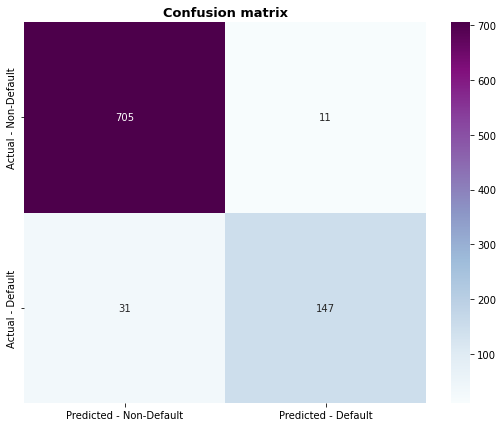

In [205]:
conf_mat_plot(conf_matrix)

Calculating other metrics
- F1, Recall, Precision, Acuraccy, AUC, Gini, Kolmogorov-Smirnov, Brier

In [206]:
def evaluation_metrics(model, X: pd.DataFrame, y: pd.Series,
                       threshold: float, target: str = 'BAD') -> pd.DataFrame:

    """

    Function for outputting a data frame which depicts a list of evaluation metrics and scores of given model.
        - based on the dataset on which the model is being evaluated.
    
    Arguments:
        x_set - Data frame of test data of features.
        true_labels - Data frame or Series of test data of true labels.
        model - fitted model ready for prediction.
        metrics_list - List of metrics as strings which we want to calculate.

    Output:
        Data frame with metrics' names and their values for given model.
        
    """

    metrics = {'F1': f1_score,
                'Precision': precision_score, 
                'Recall': recall_score, 
                'Accuracy': accuracy_score,
                'AUC': roc_auc_score,
                'Gini': roc_auc_score,
                'KS': ks_2samp, 
                'Brier': brier_score_loss}


    probs_evs = ['AUC','Brier']
    class_evs = ['Precision','Recall','F1', 'Accuracy']
    evs_list = []

    y_scores = model.predict_proba(X)[:, 1]
    y_preds = pd.Series(y_scores).apply(lambda x: 1 if x > threshold else 0)
    
    for metric in metrics.keys():
        if metric in probs_evs:
            evs_list.append([metric, metrics[metric](y, y_scores)])
        elif metric in class_evs:
            evs_list.append([metric, metrics[metric](y, y_preds)])
        elif metric == 'Gini':
            evs_list.append([metric, 2 * metrics[metric](y, y_scores) - 1])
        elif metric == 'KS':
            X_Y_concat = pd.concat((y, X), axis = 1)
            X_Y_concat['prob'] =  y_scores
            evs_list.append([metric, metrics[metric](X_Y_concat.loc[X_Y_concat[target] == 1, 'prob'],
                                                     X_Y_concat.loc[X_Y_concat[target] == 0, 'prob'])[0]])

    evaluation_df = pd.DataFrame(evs_list, columns = ['Metric', 'Score'])

    return evaluation_df

In [207]:
evaluation_metrics(final_model, X_test_binned_filtered, y_test, opt_threshold)

,Metric,Score
0,F1,0.875000
1,Precision,0.930380
2,Recall,0.825843
3,Accuracy,0.953020
4,AUC,0.980188
5,Gini,0.960376
6,KS,0.892081
7,Brier,0.043439


ROC curve

In [208]:
def ROC_curve_plot(model, X: pd.DataFrame, y: pd.Series, export:bool = True):
    y_pred = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    plt.figure(figsize = (10, 7))
    plt.plot(fpr,tpr,label=f"AUC = {auc*100:.2f}%")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate',  size = 11)
    plt.xlabel('False Positive Rate',  size = 11)
    plt.xticks(size = 11)
    plt.yticks(size = 11)
    plt.title('ROC curve', size = 13, fontweight=  'bold')
    plt.legend()
    plt.grid()
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/ROC_curve_FINAL.jpg', dpi = 1200)
    plt.show()

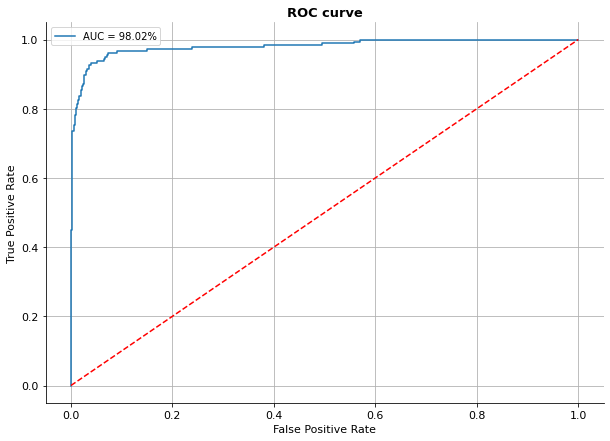

In [209]:
ROC_curve_plot(final_model, X_test_binned_filtered, y_test)

SHAP values

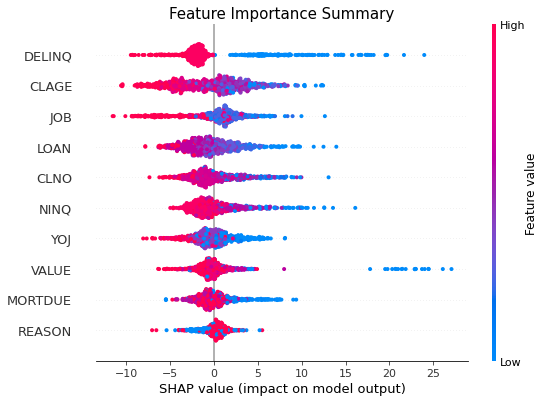

In [210]:
shap_values = shap.TreeExplainer(final_model).shap_values(X_test_binned_filtered)
fig, ax = plt.subplots(figsize=(12,15))
shap.summary_plot(shap_values, X_test_binned_filtered.values, feature_names = X_test_binned_filtered.columns, show=False)
plt.title('Feature Importance Summary', fontsize = 15)

plt.show()

Learning curve

In [211]:
def learning_curve_plot(model, x_set: pd.DataFrame, y_set: pd.Series, seed: int, export:bool = True):

    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
    
    train_sizes, train_scores, test_scores = learning_curve(model, x_set, y_set,
                                                    cv = cv, scoring = 'f1',
                                                    train_sizes = np.linspace(0.01, 1.0, 100),
                                                    random_state = seed)

    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)

    plt.plot(train_sizes, train_mean,
                color = 'blue', marker = 'o',
                markersize = 3,
                label = 'Training F1 score')

    plt.fill_between(train_sizes,
                        train_mean + train_std,
                        train_mean - train_std,
                        alpha = 0.2, color = 'blue')

    plt.plot(train_sizes, test_mean,
                color = 'green', marker = 'o',
                linestyle = '--', markersize = 3,
                label = 'Validation F1 score')

    plt.fill_between(train_sizes,
                        test_mean + test_std,
                        test_mean - test_std,
                        alpha = 0.2, color = 'green')
    
    plt.title('Learning Curve', fontweight=  'bold')
    plt.xlabel('Training set size')
    plt.ylabel('F1 score')

    plt.grid()
    plt.legend(loc = 'best')

    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Learning_Curve_FINAL.jpg', dpi = 1200)
    plt.show()

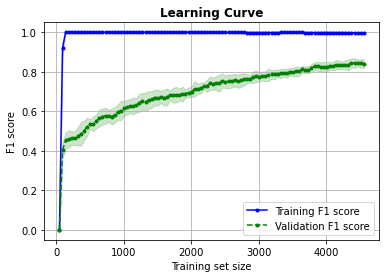

In [212]:
learning_curve_plot(final_model, X_train_valid_binned_filtered, y_train_valid, seed)